*This study was conducted for skills demonstration purposes only*

# **Forecasting the UK Construction Sector with Macroeconomic Indicators**
# Section 3. Data Preprocessing

This section pre-processes the collected in the '2_Data Collection.ipynb' file time series to make them suitable for analysis and modeling. 

Key tasks include:
1. Each dataset cleaning and formatting:
    - cleaning metadata and empty rows/columns
    - cleaning out irrelevant data beyond the period from January 2006 to Mar 2025
    - filling in missing data if necessary
    - Seasonal adjusting non seasonal adjusted data
    - converting monthly data into quarterly if necessary
2. Merging all data sets into 4 dataframes: df_q_eda, df_q_eda_add, df_m_model, df_q_model
3. Data normalizing for EDA
4. Data differentiation for Modeling
5. Checking for Outliers using Z-Score Method, adding dummy variables¶

### Collected Data

In 2_Data_Collection.ipynb file time series data on macroeconomic and construction sector indicators from official statistical sources were collected. The list of saved datasets is presented in the table below.


| N  | Indicators                                                 | Unit                       | Frequency                    | Seasonal Adjustment           | Data Source                            | File Name                                                                      | Data Preprocessing for EDA                         | Data Preprocessing for Modeling                                               |
| :- | :--------------------------------------------------------- | :------------------------- | :--------------------------- | :---------------------------- | :------------------------------------- | :----------------------------------------------------------------------------- | :------------------------------------------------- | :---------------------------------------------------------------------------- |
|    | **Macroeconomic Indicators (independent variables)**       |                            |                              |                               |                                        |                                                                                |                                                    |                                                                               |
| 1  | Consumer Price Index incl. housing (CPIH) / Inflation      | chained volume index       | annually, quarterly, monthly | NSA                           | Office for National Statistics (ONS)   | df\_1\_raw\.csv                                                                | seasonal adj -> normalization -> (df\_q\_eda)      | seasonal adj -> log diff -> standardization -> (df\_m\_model, df\_q\_model)   |
| 2  | GDP growth rate (UK, real)                                 | chained volume index       | monthly                      | SA                            | Office for National Statistics (ONS)   | df\_2\_raw\.csv                                                                | normalization -> (df\_q\_eda)                      | log diff -> standardization -> (df\_m\_model, df\_q\_model)                   |
| 3  | Employment rate or unemployment rate                       | %                          | annually, quarterly, monthly | SA                            | Office for National Statistics (ONS)   | df\_3\_raw\.csv                                                                | normalization -> (df\_q\_eda)                      | plain diff -> standardization -> (df\_q\_model)                               |
| 4  | Interest rate (Bank of England base rate)                  | %                          | monthly                      | no seasonality                | Bank of England                        | df\_4\_raw\.csv                                                                | normalization -> (df\_q\_eda)                      | plain diff -> standardization -> (df\_m\_model, df\_q\_model)                 |
| 5  | Exchange rate (GBP/USD and GBP/EUR)                        | proportion                 | monthly                      | no seasonality                | Bank of England                        | df\_5\_1\_raw\.csv, df\_5\_2\_raw\.csv                                         | normalization -> (df\_q\_eda)                      | log diff -> standardization -> (df\_m\_model, df\_q\_model)                   |
| 6  | Business investment (gross fixed capital formation)        | % change                   | quarterly                    | SA                            | Office for National Statistics (ONS)   | df\_6\_raw\.csv                                                                | normalization -> (df\_q\_eda)                      | plain diff -> standardization -> (df\_q\_model)                               |
| 7  | Government spending                                        | £m                         | annually, quarterly, monthly | NSA                           | Office for National Statistics (ONS)   | df\_7\_raw\.csv                                                                | seasonal adj -> normalization -> (df\_q\_eda)      | seasonal adj -> plain diff -> standardization -> (df\_m\_model, df\_q\_model) |
|    | **Construction Sector Indicators (dependent variables)**   |                            |                              |                               |                                        |                                                                                |                                                    |                                                                               |
| 8  | Construction output (total, residential, commercial)       | chained volume index       | annually, quarterly, monthly | SA                            | Office for National Statistics (ONS)   | df\_8\_raw\.csv                                                                | normalization -> (df\_q\_eda)                      | log diff -> standardization -> (df\_m\_model, df\_q\_model)                   |
| 9  | Construction material prices (2006-2024)                   | chained volume index       | monthly                      | NSA                           | Department for Business & Trade Gov.uk | df\_9\_1\_raw\.csv, df\_9\_2\_raw\.csv, df\_9\_3\_raw\.csv, df\_9\_4\_raw\.csv | seasonal adj -> normalization -> (df\_q\_eda\_add) | seasonal adj -> log diff -> standardization -> (df\_m\_model, df\_q\_model)   |
| 10 | Number of construction firms (2006-2023)                   | number of people           | annually                     | no seasonality in annual data | Office for National Statistics (ONS)   | df\_10\_raw\.csv                                                               | normalization -> (df\_q\_eda\_add)                 | not applicable                                                                |
| 11 | Number of employees in the construction sector (2006-2023) | number of people           | annually                     | no seasonality in annual data | Office for National Statistics (ONS)   | df\_11\_raw\.csv                                                               | normalization -> (df\_q\_eda\_add)                 | not applicable                                                                |
| 12 | Number and value of new construction contracts/orders      | chained volume index       | annually, quarterly          | SA                            | Office for National Statistics (ONS)   | df\_12\_raw\.csv                                                               | normalization -> (df\_q\_eda)                      | log diff -> standardization -> (df\_q\_model)                                 |
| 13 | UK Workforce Jobs SA : F Construction                      | number of jobs (thousands) | quarterly                    | SA                            | Office for National Statistics (ONS)   | df\_13\_raw\.csv                                                               | normalization -> (df\_q\_eda)                      | log diff -> standardization -> (df\_q\_model)                                 |


### Tools and Libraries

In [1]:
pip install odfpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install ezodf odfpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install xlrd

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import BytesIO
from io import StringIO
import ezodf
from statsmodels.tsa.seasonal import STL
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
import warnings, re
from statsmodels.tools.sm_exceptions import InterpolationWarning

### Auxiliary Functions

In [5]:
#Function for reshaping data from wide format to long date format:
def reshape_from_wide_to_date_series(df, value_name): 

    #Melt the DataFrame to long format
    df_new = df.melt(id_vars=df.columns[0], 
                          var_name='Year', 
                          value_name=value_name)

    #Rename the month column
    df_new = df_new.rename(columns={df.columns[0]: 'Month'})

    # Combine 'Year' and 'Month' into a 'Date' column
    df_new['Date'] = pd.to_datetime(df_new['Year'].astype(str) + '-' + df_new['Month'].str.strip(), format='%Y-%B')

    # Drop 'Year' and 'Month' if not needed
    df_new = df_new[[value_name, 'Date']]

    # Sort by date
    df_new = df_new.sort_values('Date').reset_index(drop=True)

    return df_new

In [6]:
# Primary data cleaning from meta-data and empty rows and columns (for .xls and .ods files)
def cleaning_meta_data_empty_rows_columns(df_raw, N_extra_upper_rows):

    # Drop upper rows 
    df = df_raw[N_extra_upper_rows:]

    #Set cleaned row 0 as the header
    new_header = []
    for col in df.iloc[0]:
        if pd.isna(col):
            new_header.append('')
        elif isinstance(col, float):
            new_header.append(int(col))
        else:
            new_header.append(str(col))
    
    df = df[1:]                      # take the data less the header row
    df.columns = new_header  

    # Drop completely empty rows and columns
    df = df.dropna(axis=0, how='all')
    df = df.dropna(axis=1, how='all')

    # Reset the index
    df.reset_index(drop=True, inplace=True)

    return df

In [7]:
# Plot a simple time series graph for preliminary data assessment
def plot_time_series_graph(df, color='blue', title = "Monthly Data Trend"):
    plt.figure(figsize=(7, 2))  # Set the size of the plot
    plt.plot(df, label=df.columns[0], color=color, linewidth=1)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(df.columns[0])
    plt.grid(True)
    plt.xticks(rotation=45)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [8]:
# Simple line plot of a quarterly series
def plot_quarterly_level(df, col, color='blue', title = 'Quarterly Data'):
    s = pd.to_numeric(df[col], errors='coerce').dropna()
    x = s.index.to_timestamp(how='end')  # use quarter-end dates for the x-axis

    fig, ax = plt.subplots(figsize=(7, 2))
    ax.plot(x, s.values, linewidth=1, color=color)
    ax.set_title(title)
    ax.set_xlabel('Quarter')
    ax.set_ylabel(col)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    plt.show()

In [9]:
# Creating a quarterly dataframe using mean monthly data
def make_mean_q_from_m(df_m):
    #Creating quarterly dataset
    df_q = df_m.copy()
    df_q = df_q.resample('QE-DEC').mean()

    # Use a quarterly PeriodIndex
    df_q.index = df_q.index.to_period('Q-DEC')
    return df_q

In [10]:
# Creating a quarterly dataframe using sum monthly data
def make_sum_q_from_m(df_m):
    #Creating quarterly dataset
    df_q = df_m.copy()
    df_q = df_q.resample('QE-DEC').sum()

    # Use a quarterly PeriodIndex
    df_q.index = df_q.index.to_period('Q-DEC')
    return df_q

## 1. Data cleaning and formatting to df_m (monthly data) df_q (quarterly data)

#### Indicator 1: Consumer Price Index incl. housing (CPIH)

- Source: Office for National Statistics (ONS)
- Frequency: annually, quarterly, monthly
- Coverage: Jan 1988 - May 2025
- CPIH INDEX 00: ALL ITEMS 2015=100
- Release date: 18-Jun-2025
- Next release: 16-Jul-2025

In [11]:
#Extract data from a saved file
df_1 = pd.read_csv('df_1_raw.csv')
df_1.head(3)

,Date,CPIH
0,1988,48.2
1,1989,51.0
2,1990,55.1


In [12]:
#Check info of the dataframe
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    637 non-null    object 
 1   CPIH    637 non-null    float64
dtypes: float64(1), object(1)
memory usage: 10.1+ KB


In [13]:
# Determine the required monthly data interval:
df_1_m = df_1.copy()
df_1_q = df_1.copy()
print(df_1_m[df_1_m['Date'] == '2006 JAN'])
print(df_1_m[df_1_m['Date'] == '2025 MAR'])

         Date  CPIH
403  2006 JAN  80.0
         Date   CPIH
633  2025 MAR  136.1


In [14]:
#Extracting the required data interval:
df_1_m = df_1_m.iloc[403:634].reset_index(drop=True)
print(df_1_m)

         Date   CPIH
0    2006 JAN   80.0
1    2006 FEB   80.2
2    2006 MAR   80.4
3    2006 APR   80.9
4    2006 MAY   81.3
..        ...    ...
226  2024 NOV  134.6
227  2024 DEC  135.1
228  2025 JAN  135.1
229  2025 FEB  135.6
230  2025 MAR  136.1

[231 rows x 2 columns]


In [15]:
#Changing the 'Date' column type to datetime64[ns]
#For convenience, we will assign the average value for the month to the first day of the month
df_1_m['Date'] = pd.to_datetime(df_1_m['Date'], format='%Y %b')
df_1_m = df_1_m.set_index('Date')

print(df_1_m.dtypes)
print(df_1_m.head(3))

CPIH    float64
dtype: object
            CPIH
Date            
2006-01-01  80.0
2006-02-01  80.2
2006-03-01  80.4


#### Seasonal Adjustment

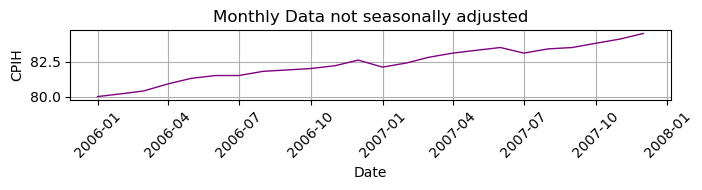

In [16]:
#Visualization of 2 years interval monthly
plot_time_series_graph(df_1_m.iloc[:24,:], 'purple', 'Monthly Data not seasonally adjusted')

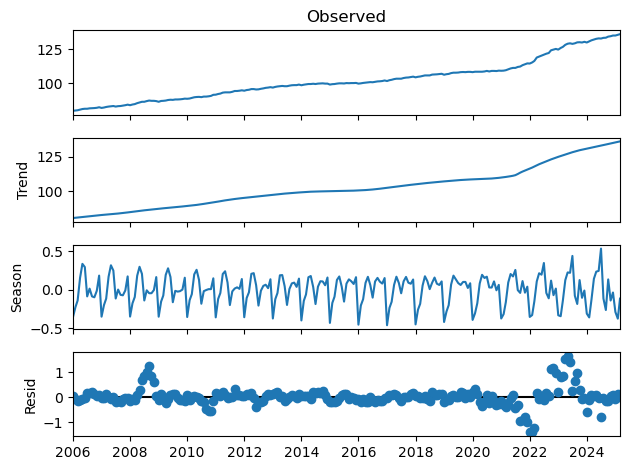

In [17]:
# Perform STL decomposition
# 13 periods for yearly seasonality in monthly data
stl = STL(df_1_m, period=12, seasonal=13, robust=True)
result1 = stl.fit()
# Plot the decomposition
result1.plot()
plt.show()

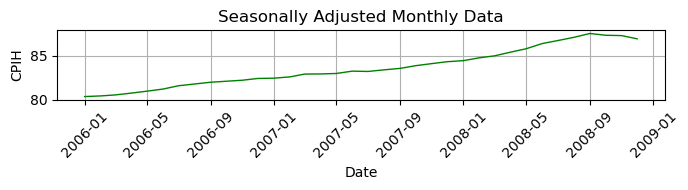

In [18]:
# Extract the seasonally adjusted data
df_1_m_seasonality = result1.seasonal.to_frame()
df_1_m.iloc[:, 0] = df_1_m.iloc[:, 0] - df_1_m_seasonality.iloc[:, 0]
#Visualization of 3 years interval 
plot_time_series_graph(df_1_m.iloc[:36,:], 'green', 'Seasonally Adjusted Monthly Data')

In [19]:
#Create a quarterly dataframe
df_1_q = make_mean_q_from_m(df_1_m)
df_1_q

,CPIH
Date,
2006Q1,80.437510
2006Q2,80.972408
2006Q3,81.785671
2006Q4,82.242322
2007Q1,82.653351
...,...
2024Q1,131.064092
2024Q2,132.426323
2024Q3,133.214105


#### Indicator 2: Gross Domestic Product (GDP). Chained volume measures: Seasonally adjusted £m

- Source: Office for National Statistics (ONS)
- Frequency: annually, quarterly
- Coverage: Q1 1955 - Q1 2025
- Release date: 15-May-2025
- Next release: 30-Jun-2025

In [20]:
#Extract data from a saved file
df_2 = pd.read_csv('df_2_raw.csv')
df_2.head(5)

,0,1,2,3,4,5
0,Monthly GDP and main sectors to 4 decimal places,NaN,NaN,NaN,NaN,NaN
1,This worksheet contains one table. Some cells ...,NaN,NaN,NaN,NaN,NaN
2,"Source: GDP monthly estimate, Office for Nati...",NaN,NaN,NaN,NaN,NaN
3,Month,Monthly GDP (A-T),Agriculture (A),"Construction (F) [note1],[note 2]",Production (B-E),Services (G-T)
4,1997JAN,61.9985,51.1856,84.5216,85.6482,57.4413


In [21]:
#Data cleaning from meta-data and empty rows and columns
df_2 = cleaning_meta_data_empty_rows_columns(df_2, 3)
df_2.head(3)

,Month,Monthly GDP (A-T),Agriculture (A),"Construction (F) [note1],[note 2]",Production (B-E),Services (G-T)
0,1997JAN,61.9985,51.1856,84.5216,85.6482,57.4413
1,1997FEB,62.5399,51.98,85.1487,85.8215,58.0562
2,1997MAR,62.5939,52.8298,86.0587,84.8495,58.2625


In [22]:
#Drop unnecessary columns
df_2 = df_2[['Month', 'Production (B-E)', 'Services (G-T)']]
df_2.head(3)

,Month,Production (B-E),Services (G-T)
0,1997JAN,85.6482,57.4413
1,1997FEB,85.8215,58.0562
2,1997MAR,84.8495,58.2625


In [23]:
#Rename columns
df_2.columns = ['Date', 'Production GDP', 'Services GDP']
df_2.head(3)

,Date,Production GDP,Services GDP
0,1997JAN,85.6482,57.4413
1,1997FEB,85.8215,58.0562
2,1997MAR,84.8495,58.2625


In [24]:
# to avoid not working on a view warnings
df_2 = df_2.copy()

# normalize and parse "YYYYMon" -> datetime -> monthly Period
s = (df_2['Date'].astype(str)
                 .str.strip().str.upper()
                 .str.replace('SEPT', 'SEP', regex=False))

df_2['Date'] = pd.to_datetime(s, format='%Y%b', errors='raise')
df_2.head(3)

,Date,Production GDP,Services GDP
0,1997-01-01,85.6482,57.4413
1,1997-02-01,85.8215,58.0562
2,1997-03-01,84.8495,58.2625


In [25]:
#Check info of the dataframe
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341 entries, 0 to 340
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            341 non-null    datetime64[ns]
 1   Production GDP  341 non-null    object        
 2   Services GDP    341 non-null    object        
dtypes: datetime64[ns](1), object(2)
memory usage: 8.1+ KB


In [26]:
# Determine the required data interval:
print(df_2[df_2['Date'] == pd.to_datetime('2006-01-01')])
print(df_2[df_2['Date'] == pd.to_datetime('2025-03-01')])

          Date Production GDP Services GDP
108 2006-01-01       107.2311      76.7727
          Date Production GDP Services GDP
338 2025-03-01        99.1824     103.1848


In [27]:
#Extracting the required data interval:
df_2 = df_2.iloc[108:339].reset_index(drop=True)
df_2

,Date,Production GDP,Services GDP
0,2006-01-01,107.2311,76.7727
1,2006-02-01,107.2069,76.6965
2,2006-03-01,108.435,76.8872
3,2006-04-01,108.7334,76.5804
4,2006-05-01,109.5902,76.8779
...,...,...,...
226,2024-11-01,97.0372,102.0178
227,2024-12-01,97.9726,102.4453
228,2025-01-01,97.6975,102.4838
229,2025-02-01,99.3864,102.7525


In [28]:
#Setting the 'Date' column as an index column
df_2 = df_2.set_index('Date')

#Converting values to float type
df_2 = df_2.astype(float)

print(df_2.dtypes)
df_2.head(3)

Production GDP    float64
Services GDP      float64
dtype: object


,Production GDP,Services GDP
Date,,
2006-01-01,107.2311,76.7727
2006-02-01,107.2069,76.6965
2006-03-01,108.4350,76.8872


In [29]:
df_2_m = df_2.copy()

In [30]:
#Creating quarterly dataset
df_2_q = make_mean_q_from_m(df_2_m)
df_2_q

,Production GDP,Services GDP
Date,,
2006Q1,107.624333,76.785467
2006Q2,109.472000,76.816567
2006Q3,109.874733,76.934333
2006Q4,109.425633,77.487767
2007Q1,108.405100,78.714033
...,...,...
2024Q1,98.713400,101.366533
2024Q2,98.220433,101.979167
2024Q3,97.884200,101.999667


#### Indicator 3: Employment rate (aged 16 to 64, seasonally adjusted): %
- Source: Office for National Statistics (ONS)
- Frequency: annually, quarterly, monthly
- Coverage: Feb 1971 - Mar 2025
- Release date: 10-Jun-2025
- Next release: 17-Jul-2025

We will use the quarterly employment rate only because the ONS “monthly” figure is a 3-month rolling average, which makes MoM diffs look spiky for window-overlap reasons rather than true shocks. Using the quarterly series matches the indicator’s construction and gives cleaner, more stationary percentage-point changes for modeling.

In [31]:
#Extract data from a saved file
df_3 = pd.read_csv('df_3_raw.csv')
df_3.head(3)

,Date,"Employment rate, %"
0,1971,71.8
1,1972,72.0
2,1973,72.9


In [32]:
#Check info of the dataframe
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924 entries, 0 to 923
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                924 non-null    object 
 1   Employment rate, %  924 non-null    float64
dtypes: float64(1), object(1)
memory usage: 14.6+ KB


In [33]:
# Determine the required data intervals:
print(df_3[df_3['Date'] == '2006 Q1'])
print(df_3[df_3['Date'] == '2025 Q1'])

        Date  Employment rate, %
194  2006 Q1                72.9
        Date  Employment rate, %
270  2025 Q1                75.0


In [34]:
#Extracting the required data interval:
df_3_q = df_3.iloc[194:271].reset_index(drop=True)
print(df_3_q)

       Date  Employment rate, %
0   2006 Q1                72.9
1   2006 Q2                72.8
2   2006 Q3                72.8
3   2006 Q4                72.7
4   2007 Q1                72.5
..      ...                 ...
72  2024 Q1                74.5
73  2024 Q2                74.6
74  2024 Q3                74.9
75  2024 Q4                75.0
76  2025 Q1                75.0

[77 rows x 2 columns]


In [35]:
#Changing the 'Date' column type to PeriodIndex
q_period = pd.PeriodIndex(
    df_3_q['Date'].astype(str).str.replace(r'\s+', '', regex=True),
    freq='Q-DEC'
)

df_3_q = (df_3_q
          .drop(columns='Date')
          .set_index(q_period)
          .sort_index())
df_3_q.index.name = 'Quarter'

print(df_3_q.dtypes)
print(df_3_q.head(3))

Employment rate, %    float64
dtype: object
         Employment rate, %
Quarter                    
2006Q1                 72.9
2006Q2                 72.8
2006Q3                 72.8


#### Indicator 4: Month average Bank Rate

- Source: Bank of England (BoE)
- Frequency: monthly
- Coverage: Jan 2000 - Jun 2025
- Release date: 30-Jun-2025
- Next release: 31-Jul-2025

In [36]:
#Extract data from a saved file
df_4 = pd.read_csv('df_4_raw.csv')
df_4.head(3)

,Date,"BoE Rate, %"
0,2005-01-31,4.75
1,2005-02-28,4.75
2,2005-03-31,4.75


In [37]:
#Check info of the dataframe
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         245 non-null    object 
 1   BoE Rate, %  245 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.0+ KB


In [38]:
#Changing the 'Date' column type to datetime64[ns]
df_4['Date'] = pd.to_datetime(df_4['Date'])

#For convenience, we will reassign the average value for the month to the first day of the month
df_4['Date'] = df_4['Date'].apply(lambda d: d.replace(day=1))

df_4.head(3)

,Date,"BoE Rate, %"
0,2005-01-01,4.75
1,2005-02-01,4.75
2,2005-03-01,4.75


In [39]:
# Determine the required data interval:
print(df_4[df_4['Date'] == '2006-01-01'])
print(df_4[df_4['Date'] == '2025-03-01'])

         Date  BoE Rate, %
12 2006-01-01          4.5
          Date  BoE Rate, %
242 2025-03-01          4.5


In [40]:
#Extracting the required data interval:
df_4 = df_4.iloc[12:243].reset_index(drop=True)

#Setting the 'Date' column as an index column
df_4 = df_4.set_index('Date')
df_4

,"BoE Rate, %"
Date,
2006-01-01,4.50
2006-02-01,4.50
2006-03-01,4.50
2006-04-01,4.50
2006-05-01,4.50
...,...
2024-11-01,4.75
2024-12-01,4.75
2025-01-01,4.75


In [41]:
#Monthly dataset
df_4_m = df_4.copy()

In [42]:
#Quartrerly dataset creation
df_4_q = df_4.copy()
df_4_q = df_4_q.resample('QE-DEC').mean()

# Using a quarterly PeriodIndex
df_4_q.index = df_4_q.index.to_period('Q-DEC')
df_4_q.name = 'BoE_Rate_q'
df_4_q

,"BoE Rate, %"
Date,
2006Q1,4.500000
2006Q2,4.500000
2006Q3,4.666667
2006Q4,4.916667
2007Q1,5.250000
...,...
2024Q1,5.250000
2024Q2,5.250000
2024Q3,5.083333


#### Indicators 5.1 and 5.2: Exchange rates (GBP/USD and GBP/EUR)
- Source: Bank of England (BoE)
- Frequency: monthly average
- Coverage: Jan 2005 - Jul 2025
- Link update : 15-Jul-2025
- Release: every day

**GBP/EUR**

In [43]:
#Extract data from a saved file
df_5_1 = pd.read_csv('df_5_1_raw.csv')
df_5_1.head(3)

,Date,EUR/GBP
0,2005-01-31,1.4331
1,2005-02-28,1.4499
2,2005-03-31,1.4440


In [44]:
#Check info of the dataframe
df_5_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     246 non-null    object 
 1   EUR/GBP  246 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.0+ KB


In [45]:
#Changing the 'Date' column type to datetime64[ns]
df_5_1['Date'] = pd.to_datetime(df_5_1['Date'])

#For convenience, we will reassign the average value for the month to the first day of the month
df_5_1['Date'] = df_5_1['Date'].apply(lambda d: d.replace(day=1))

df_5_1.head(3)

,Date,EUR/GBP
0,2005-01-01,1.4331
1,2005-02-01,1.4499
2,2005-03-01,1.4440


In [46]:
# Determine the required data interval:
print(df_5_1[df_5_1['Date'] == '2006-01-01'])
print(df_5_1[df_5_1['Date'] == '2025-03-01'])

         Date  EUR/GBP
12 2006-01-01   1.4582
          Date  EUR/GBP
242 2025-03-01   1.1941


In [47]:
#Extracting the required data interval:
df_5_1 = df_5_1.iloc[12:243].reset_index(drop=True)

#Setting the 'Date' column as an index column
df_5_1 = df_5_1.set_index('Date')
df_5_1

,EUR/GBP
Date,
2006-01-01,1.4582
2006-02-01,1.4637
2006-03-01,1.4500
2006-04-01,1.4402
2006-05-01,1.4637
...,...
2024-11-01,1.1998
2024-12-01,1.2079
2025-01-01,1.1921


In [48]:
#Monthly Dataset
df_5_1_m = df_5_1.copy()

In [49]:
#Quarterly dataset creation
df_5_1_q = df_5_1.copy()
df_5_1_q = df_5_1_q.resample('QE-DEC').mean()

# Use a quarterly PeriodIndex
df_5_1_q.index = df_5_1_q.index.to_period('Q-DEC')
df_5_1_q.name = 'EUR/GBP_q'
df_5_1_q

,EUR/GBP
Date,
2006Q1,1.457300
2006Q2,1.453300
2006Q3,1.471200
2006Q4,1.485433
2007Q1,1.491700
...,...
2024Q1,1.168267
2024Q2,1.172233
2024Q3,1.183467


**GBP/USD**

In [50]:
#Extract data from a saved file
df_5_2 = pd.read_csv('df_5_2_raw.csv')
df_5_2.head(5)

,Date,USD/GBP
0,2005-01-31,1.8764
1,2005-02-28,1.8871
2,2005-03-31,1.9078
3,2005-04-30,1.8960
4,2005-05-31,1.8538


In [51]:
#Check info of the dataframe
df_5_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     247 non-null    object 
 1   USD/GBP  247 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.0+ KB


In [52]:
#Changing the 'Date' column type to datetime64[ns]
df_5_2['Date'] = pd.to_datetime(df_5_2['Date'])

#For convenience, we will reassign the average value for the month to the first day of the month
df_5_2['Date'] = df_5_2['Date'].apply(lambda d: d.replace(day=1))
df_5_2.head(3)

,Date,USD/GBP
0,2005-01-01,1.8764
1,2005-02-01,1.8871
2,2005-03-01,1.9078


In [53]:
# Determine the required data interval:
print(df_5_2[df_5_2['Date'] == '2006-01-01'])
print(df_5_2[df_5_2['Date'] == '2025-03-01'])

         Date  USD/GBP
12 2006-01-01   1.7678
          Date  USD/GBP
242 2025-03-01   1.2911


In [54]:
#Extracting the required data interval:
df_5_2 = df_5_2.iloc[12:243].reset_index(drop=True)

#Setting the 'Date' column as an index column
df_5_2 = df_5_2.set_index('Date')
df_5_2

,USD/GBP
Date,
2006-01-01,1.7678
2006-02-01,1.7470
2006-03-01,1.7435
2006-04-01,1.7685
2006-05-01,1.8702
...,...
2024-11-01,1.2750
2024-12-01,1.2647
2025-01-01,1.2348


In [55]:
#Monthly dataset
df_5_2_m = df_5_2.copy()

In [56]:
#Quarterly Dataset creation
df_5_2_q = df_5_2.copy()
df_5_2_q = df_5_2_q.resample('QE-DEC').mean()

# Use a quarterly PeriodIndex
df_5_2_q.index = df_5_2_q.index.to_period('Q-DEC')
df_5_2_q.name = 'USD/GBP_q'
df_5_2_q

,USD/GBP
Date,
2006Q1,1.752767
2006Q2,1.827167
2006Q3,1.874600
2006Q4,1.916900
2007Q1,1.954633
...,...
2024Q1,1.267967
2024Q2,1.261867
2024Q3,1.300433


In [57]:
#Merging data for EUR and USD
df_5_m = pd.merge(df_5_1_m, df_5_2_m, on='Date', how='inner')
df_5_q = pd.merge(df_5_1_q, df_5_2_q, on='Date', how='inner')
print(df_5_m.head(3))
print(df_5_q.head(3))

            EUR/GBP  USD/GBP
Date                        
2006-01-01   1.4582   1.7678
2006-02-01   1.4637   1.7470
2006-03-01   1.4500   1.7435
        EUR/GBP   USD/GBP
Date                     
2006Q1   1.4573  1.752767
2006Q2   1.4533  1.827167
2006Q3   1.4712  1.874600


#### Indicator 6: Business Investment (CVM, Seasonally Adjusted, % change)
- Source: Office for National Statistics (ONS)
- Frequency: quarterly
- Coverage: Q2 1997 - Q1 2025
- Release date: 15-May-2025
- Next release: 30-Jun-2025

In [58]:
#Extract data from a saved file
df_6 = pd.read_csv('df_6_raw.csv')
df_6.head(3)

,Date,"Business Investment, % change"
0,1997 Q2,4.4
1,1997 Q3,6.1
2,1997 Q4,2.6


In [59]:
#Check info of the dataframe
df_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date                           112 non-null    object 
 1   Business Investment, % change  112 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.9+ KB


In [60]:
# Determine the required data interval:
print(df_6[df_6['Date'] == '2006 Q1'])
print(df_6[df_6['Date'] == '2025 Q1'])

       Date  Business Investment, % change
35  2006 Q1                            5.1
        Date  Business Investment, % change
111  2025 Q1                            5.9


In [61]:
#Extracting the required data interval:
df_6 = df_6.iloc[35:112].reset_index(drop=True)
df_6

,Date,"Business Investment, % change"
0,2006 Q1,5.1
1,2006 Q2,-3.9
2,2006 Q3,7.7
3,2006 Q4,0.2
4,2007 Q1,4.8
...,...,...
72,2024 Q1,-0.2
73,2024 Q2,1.8
74,2024 Q3,2.2
75,2024 Q4,-1.9


In [62]:
#Changing the 'Date' column type to PeriodIndex
df_6_q = df_6.copy()
q_period = pd.PeriodIndex(
    df_6_q['Date'].astype(str).str.replace(r'\s+', '', regex=True),
    freq='Q-DEC'
)

df_6_q = (df_6_q
          .drop(columns='Date')
          .set_index(q_period)
          .sort_index())
df_6_q.index.name = 'Quarter'

print(df_6_q.dtypes)
print(df_6_q.head(3))

Business Investment, % change    float64
dtype: object
         Business Investment, % change
Quarter                               
2006Q1                             5.1
2006Q2                            -3.9
2006Q3                             7.7


#### Indicator 7: Total managed expenditure: £m

- Source: Office for National Statistics (ONS)
- Frequency: annually, quarterly, monthly
- Coverage: Apr 1997 - May 2025
- Release date: 20-Jun-2025
- Next release: 20-Jul-2025

In [63]:
#Extract data from a saved file
df_7 = pd.read_csv('df_7_raw.csv')
df_7.head(3)

,Date,"Govt Expenditure, £m"
0,1998,5466
1,1999,4672
2,2000,4337


In [64]:
#Check info of the dataframe
df_7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Date                  479 non-null    object
 1   Govt Expenditure, £m  479 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.6+ KB


In [65]:
# Determine the required data intervals:
print(df_7[df_7['Date'] == '2006 JAN'])
print(df_7[df_7['Date'] == '2025 MAR'])

         Date  Govt Expenditure, £m
245  2006 JAN                  3607
         Date  Govt Expenditure, £m
475  2025 MAR                 16955


In [66]:
#Extracting the required data interval:
df_7_m = df_7.iloc[245:476].reset_index(drop=True)
print(df_7_m)

         Date  Govt Expenditure, £m
0    2006 JAN                  3607
1    2006 FEB                  3667
2    2006 MAR                  3602
3    2006 APR                  2080
4    2006 MAY                  1111
..        ...                   ...
226  2024 NOV                  4307
227  2024 DEC                  8303
228  2025 JAN                  8825
229  2025 FEB                  6664
230  2025 MAR                 16955

[231 rows x 2 columns]


In [67]:
#Changing the 'Date' column type to datetime64[ns]
#For convenience, we will assign the average value for the month to the first day of the month
df_7_m['Date'] = pd.to_datetime(df_7_m['Date'], format='%Y %b')
df_7_m = df_7_m.set_index('Date').astype(float)

print(df_7_m.dtypes)
print(df_7_m.head(5))

Govt Expenditure, £m    float64
dtype: object
            Govt Expenditure, £m
Date                            
2006-01-01                3607.0
2006-02-01                3667.0
2006-03-01                3602.0
2006-04-01                2080.0
2006-05-01                1111.0


#### Seasonal Adjustment

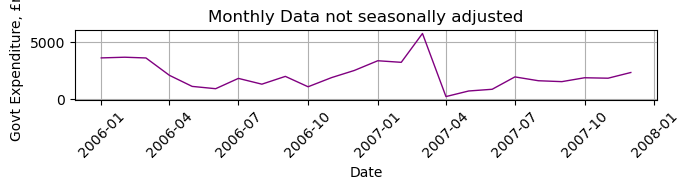

In [68]:
#Visualization of 2 years interval monthly
plot_time_series_graph(df_7_m.iloc[:24,:], 'purple', 'Monthly Data not seasonally adjusted')

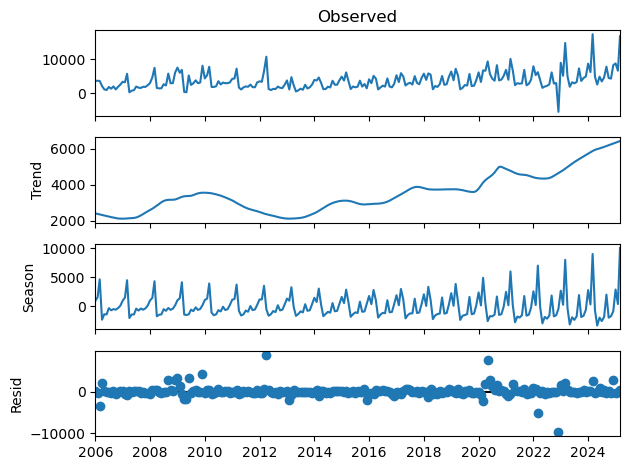

In [69]:
# Perform STL decomposition
# 13 periods for yearly seasonality in monthly data
stl = STL(df_7_m, period=12, seasonal=13, robust=True)
result1 = stl.fit()
# Plot the decomposition
result1.plot()
plt.show()

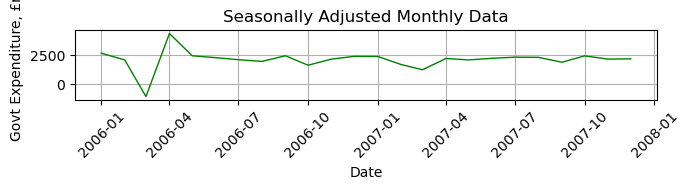

In [70]:
# Extract the seasonally adjusted data
df_7_m_seasonality = result1.seasonal.to_frame()
df_7_m.iloc[:, 0] = df_7_m.iloc[:, 0] - df_7_m_seasonality.iloc[:, 0]
#Visualization of 3 years interval 
plot_time_series_graph(df_7_m.iloc[:24,:], 'green', 'Seasonally Adjusted Monthly Data')

In [71]:
#Creating quarterly dataset
df_7_q = make_sum_q_from_m(df_7_m)
df_7_q

,"Govt Expenditure, £m"
Date,
2006Q1,3712.618937
2006Q2,9101.255103
2006Q3,6530.808830
2006Q4,6204.016512
2007Q1,5335.053191
...,...
2024Q1,20402.788656
2024Q2,18168.030920
2024Q3,18262.932977


#### Indicator 8: Construction output (Seasonally Adjusted, total, residential, commercial): £m
- Source: Office for National Statistics (ONS)
- Frequency: annually, quarterly, monthly (from 2010)
- Coverage: Q1 1997 - May 2025
- Release date: 11-Jul-2025
- Next release: 14-Aug-2025

In [72]:
#Extract data from a saved file
df_8 = pd.read_csv('df_8_raw.csv')
df_8.head(3)

,v4_1,Data Marking,years-quarters-months,Time,administrative-geography,Geography,seasonal-adjustment,SeasonalAdjustment,construction-series-type,SeriesType,construction-classifications,TypeOfWork
0,69.7,NaN,2015,2015,K03000001,Great Britain,seasonal-adjustment,Seasonally adjusted,index-numbers,Index numbers (2019=100),1-2-3,Infrastructure new work
1,70.4,NaN,2015,2015,K03000001,Great Britain,seasonal-adjustment,Seasonally adjusted,index-numbers,Index numbers (2019=100),1-2-1-2,Private new housing
2,74.6,NaN,2015,2015,K03000001,Great Britain,seasonal-adjustment,Seasonally adjusted,index-numbers,Index numbers (2019=100),1-2-1,Total new housing


In [73]:
#Check info of the dataframe
df_8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4564 entries, 0 to 4563
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   v4_1                          4564 non-null   float64
 1   Data Marking                  0 non-null      float64
 2   years-quarters-months         4564 non-null   object 
 3   Time                          4564 non-null   object 
 4   administrative-geography      4564 non-null   object 
 5   Geography                     4564 non-null   object 
 6   seasonal-adjustment           4564 non-null   object 
 7   SeasonalAdjustment            4564 non-null   object 
 8   construction-series-type      4564 non-null   object 
 9   SeriesType                    4564 non-null   object 
 10  construction-classifications  4564 non-null   object 
 11  TypeOfWork                    4564 non-null   object 
dtypes: float64(2), object(10)
memory usage: 428.0+ KB


In [74]:
#Filtering data by the column "TypeOfWork" for "All Works"
df_8 = df_8[df_8['TypeOfWork']=='All work']

#Swap 'v4_1' and 'years-quarters-months'
df_8 = df_8[['years-quarters-months', 'v4_1']]

# Changing the header
df_8.columns = ['Date', 'Construction output']

df_8.head(3)

,Date,Construction output
7,2015,86.2
18,2024-q2,102.3
31,2024-oct,102.7


In [75]:
# Filtering Data by column 'Date' for only data in monthly expression and quarterly data from 2005 till 2010 years
df_8_m = df_8[df_8['Date'].str.match(r'^\d{4}-[a-z]{3}$', case=False)]
df_8_m = df_8_m.reset_index(drop=True)

print(df_8_m.head(3))

       Date  Construction output
0  2024-oct                102.7
1  2015-oct                 86.4
2  2022-oct                101.6


In [76]:
df_8_q = df_8[df_8['Date'].str.match(r'^20(0[5-9]|1[0-9]|2[0-5])-q[1-4]$', case=False)]
df_8_q = df_8_q.sort_values(by=['Date'])
df_8_q = df_8_q.reset_index(drop=True)
df_8_q.head(3)

,Date,Construction output
0,2005-q1,85.4
1,2005-q2,84.8
2,2005-q3,83.1


In [77]:
#Changing the 'Date' column type to datetime64[ns]
#For convenience, we will assign the average value for the month to the first day of the month
df_8_m['Date'] = pd.to_datetime(df_8_m['Date'], format='%Y-%b')

#Sort by 'Date'
df_8_m = df_8_m.sort_values(by='Date')
df_8_m = df_8_m.reset_index(drop=True)

print(df_8_m.head(3))

        Date  Construction output
0 2010-01-01                 74.1
1 2010-02-01                 77.3
2 2010-03-01                 77.7


In [78]:
# 1. Build a quarterly PeriodIndex (Q1 = Jan–Mar)
qidx = pd.PeriodIndex(
    df_8_q['Date'].astype(str)
              .str.strip()
              .str.replace(r'[^0-9Qq]', '', regex=True)  # "2024-q2" -> "2024q2"
              .str.upper(),                               # "2024Q2"
    freq='Q-DEC'
)

# 2. Set index, coerce values to numeric, and sort by quarter
df_8_q = (df_8_q.drop(columns='Date')
         .assign(**{'Construction output': pd.to_numeric(df_8_q['Construction output'], errors='coerce')})
         .set_index(qidx)
         .sort_index())

df_8_q.index.name = 'Quarter'
df_8_q.head(3)

,Construction output
Quarter,
2005Q1,85.4
2005Q2,84.8
2005Q3,83.1


In [79]:
#Determine the required data intervals:
print(df_8_m[df_8_m['Date'] == '2010-01-01'])
print(df_8_m[df_8_m['Date'] == '2025-03-01'])

        Date  Construction output
0 2010-01-01                 74.1
          Date  Construction output
182 2025-03-01                103.9


In [80]:
#Extracting the required data interval:
df_8_m = df_8_m.iloc[:183].set_index('Date')
df_8_q = df_8_q.loc['2006Q1':,:]

print(df_8_m.head(3))
print(df_8_q.head(3))

            Construction output
Date                           
2010-01-01                 74.1
2010-02-01                 77.3
2010-03-01                 77.7
         Construction output
Quarter                     
2006Q1                  83.7
2006Q2                  84.3
2006Q3                  84.6


#### Indicator 9: Construction material Price Indices

**9_1. Construction Material price indices for 2020 - 2025 years**

- Source: Department for Business & Trade Gov.uk
- Frequency: monthly
- Coverage: Jan 2020 - Jan 2025
- Release date: 02-Jul-2025
- Next release: 06-Aug-2025
- Base Index: 2015 = 100

In [81]:
#Extract data from a saved file
df_9_1 = pd.read_csv('df_9_1_raw.csv')
df_9_1.head(10)

,0,1,2,3,4,5
0,Table 1a: Monthly construction material price ...,NaN,NaN,NaN,NaN,NaN
1,The publication of data contained in this work...,NaN,NaN,NaN,NaN,NaN
2,This worksheet contains one table. Some cells ...,NaN,NaN,NaN,NaN,NaN
3,"Freeze panes are turned on. To turn off, selec...",NaN,NaN,NaN,NaN,NaN
4,Source: DBT/ONS/Building cost information serv...,NaN,NaN,NaN,NaN,NaN
5,Base year: 2015=100,NaN,NaN,NaN,NaN,NaN
6,Year,Month,New Housing,Other New Work,Repair and Maintenance,All Work
7,2020,January,110.9,110.6,111.3,110.7
8,2020,February,111.4,110.7,111.7,111
9,2020,March,111.7,111.1,111.7,111.2


In [82]:
#Data cleaning from meta-data and empty rows and columns
df_9_1 = cleaning_meta_data_empty_rows_columns(df_9_1, 6)
df_9_1.head(3)

,Year,Month,New Housing,Other New Work,Repair and Maintenance,All Work
0,2020,January,110.9,110.6,111.3,110.7
1,2020,February,111.4,110.7,111.7,111
2,2020,March,111.7,111.1,111.7,111.2


In [83]:
#Check info of the dataframe
df_9_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Year                    61 non-null     object
 1   Month                   61 non-null     object
 2   New Housing             61 non-null     object
 3   Other New Work          61 non-null     object
 4   Repair and Maintenance  61 non-null     object
 5   All Work                61 non-null     object
dtypes: object(6)
memory usage: 3.0+ KB


In [84]:
#Creating the 'Date' column of type datetime64[ns]
#For convenience, we will assign the average value for the month to the first day of the month
#Convert to integers
df_9_1['Year'] = df_9_1['Year'].astype('int')

#Map month to start in JAN, FEB, MAR format
df_9_1['Month_formated'] = df_9_1['Month'].map({'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12, 'November [p]':11, 'December [p]':12, 'January [p]':1}) 

#Create a column 'Date' in datetime64 format
df_9_1['Date'] = pd.to_datetime(dict(year=df_9_1['Year'], month=df_9_1['Month_formated'], day=1)) 

print(df_9_1.dtypes)
df_9_1.head(5)

Year                               int64
Month                             object
New Housing                       object
Other New Work                    object
Repair and Maintenance            object
All Work                          object
Month_formated                     int64
Date                      datetime64[ns]
dtype: object


,Year,Month,New Housing,Other New Work,Repair and Maintenance,All Work,Month_formated,Date
0,2020,January,110.9,110.6,111.3,110.7,1,2020-01-01
1,2020,February,111.4,110.7,111.7,111,2,2020-02-01
2,2020,March,111.7,111.1,111.7,111.2,3,2020-03-01
3,2020,April,111.7,112.4,111.7,113.5,4,2020-04-01
4,2020,May,112.5,112.8,112.2,113.9,5,2020-05-01


In [85]:
#Drop unnecessary columns
df_9_1 = df_9_1[['All Work', 'Date']]

#Rename columns
df_9_1.columns = ['Constr Material Price Index', 'Date']

In [86]:
# Determine the required data interval:
print(df_9_1[df_9_1['Date'] == '2020-01-01'])
print(df_9_1[df_9_1['Date'] == '2024-12-01'])

  Constr Material Price Index       Date
0                       110.7 2020-01-01
   Constr Material Price Index       Date
59                       152.1 2024-12-01


In [87]:
#Extracting the required data interval:
df_9_1 = df_9_1.iloc[:60]

print(df_9_1.head(3))
print(df_9_1.tail(3))

  Constr Material Price Index       Date
0                       110.7 2020-01-01
1                         111 2020-02-01
2                       111.2 2020-03-01
   Constr Material Price Index       Date
57                       152.2 2024-10-01
58                       152.9 2024-11-01
59                       152.1 2024-12-01


**9_2. Construction Material price indices for 2015 - 2020 years**

- Source: Department for Business & Trade Gov.uk
- Frequency: monthly
- Coverage: Jan 2015 - Dec 2020
- Release date: 03-Feb-2021
- Base Index: 2015 = 100

In [88]:
#Extract data from a saved file
df_9_2 = pd.read_csv('df_9_2_raw.csv')
df_9_2

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PRICES
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Table 1: Construction Material Price Indices,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015=100
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,Notes: 1. These indices are weighted averages ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Source ONS/BEIS
77,electrical or mechanical engineering materials.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,2. All series have been rebased to 2015 = 100 ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
#Data cleaning from meta-data and empty rows and columns
df_9_2 = cleaning_meta_data_empty_rows_columns(df_9_2, 5)
df_9_2

,,2015,2016,2017,2018,2019,2020,
0,(a) New Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,January,100.500000,98.500000,102.800000,107.700000,111.700000,110.900000,NaN
2,February,100.600000,99.100000,103.900000,109.300000,112.400000,111.400000,NaN
3,March,100.600000,98.900000,104.300000,109.300000,113.400000,111.700000,NaN
4,April,100.600000,99.400000,104.800000,109.700000,113.100000,111.700000,NaN
5,May,100.900000,99.800000,105.200000,110.100000,112.800000,112.500000,NaN
6,June,100.500000,100.300000,105.300000,110.500000,113.300000,111.900000,NaN
7,July,100.200000,100.200000,105.400000,111.000000,113.300000,112.200000,NaN
8,August,99.800000,100.800000,105.600000,111.100000,112.800000,112.300000,NaN
9,September,99.400000,101.400000,106.400000,111.600000,112.500000,112.900000,NaN


In [90]:
#Check info of the dataframe
df_9_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0           59 non-null     object 
 1   2015    52 non-null     float64
 2   2016    52 non-null     float64
 3   2017    52 non-null     float64
 4   2018    52 non-null     float64
 5   2019    52 non-null     float64
 6   2020    52 non-null     float64
 7           18 non-null     object 
dtypes: float64(6), object(2)
memory usage: 3.9+ KB


In [91]:
#Drop unnecessary rows and columns
df_9_2 = df_9_2.iloc[43:55, :7]
df_9_2

,,2015,2016,2017,2018,2019,2020
43,January,101.2,97.4,102.6,107.1,111.8,110.7
44,February,101.0,97.7,103.3,108.0,112.6,111.0
45,March,101.3,98.1,103.6,108.5,113.1,111.2
46,April,100.7,98.3,103.9,108.7,112.9,113.5
47,May,100.9,99.2,104.0,109.3,112.9,113.9
48,June,100.6,99.5,103.9,109.7,112.3,111.8
49,July,100.6,99.6,104.1,110.1,112.7,111.6
50,August,99.8,99.8,104.4,110.4,112.2,111.6
51,September,99.1,100.2,105.1,111.0,112.3,111.6
52,October,98.7,100.2,106.0,111.0,111.9,113.7


In [92]:
#Coverting data from wide format to long date format:
df_9_2 = reshape_from_wide_to_date_series(df_9_2, 'Constr Material Price Index')

df_9_2.head(3)

,Constr Material Price Index,Date
0,101.2,2015-01-01
1,101.0,2015-02-01
2,101.3,2015-03-01


In [93]:
# Determine the required data interval:
print(df_9_2[df_9_2['Date'] == '2015-01-01'])
print(df_9_2[df_9_2['Date'] == '2019-12-01'])

   Constr Material Price Index       Date
0                        101.2 2015-01-01
    Constr Material Price Index       Date
59                        110.1 2019-12-01


In [94]:
#Extracting the required data interval:
df_9_2 = df_9_2.iloc[:60]

print(df_9_2.head(3))

   Constr Material Price Index       Date
0                        101.2 2015-01-01
1                        101.0 2015-02-01
2                        101.3 2015-03-01


#### 9_3. Construction Material price indices for 2010 - 2015 years

- Source: Department for Business & Trade Gov.uk
- Frequency: monthly
- Coverage: Jan 2010 - Dec 2015
- Release date: 03-Feb-2016
- Base Index: 2010 = 100

In [95]:
#Extract data from a saved file
df_9_3 = pd.read_csv('df_9_3_raw.csv')
df_9_3.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PRICES
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Table 1: Construction Material Price Indices,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010=100
5,NaN,2010.0,NaN,2011.0,NaN,2012.0,NaN,2013.0,NaN,2014.0,NaN,2015.0,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,(a) New Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,January,96.1,NaN,102.2,NaN,106.0,NaN,107.1,NaN,108.6,NaN,109.8,NaN


In [96]:
#Data cleaning from meta-data and empty rows and columns
df_9_3 = cleaning_meta_data_empty_rows_columns(df_9_3, 5)
df_9_3

,,2010,2011,2012,2013,2014,2015,
0,(a) New Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,January,96.100000,102.200000,106.000000,107.100000,108.600000,109.800000,NaN
2,February,96.500000,103.100000,106.400000,107.600000,109.400000,109.900000,NaN
3,March,96.900000,103.700000,107.600000,107.900000,110.000000,109.900000,NaN
4,April,98.400000,104.200000,107.900000,108.100000,110.100000,109.900000,NaN
5,May,99.900000,104.800000,107.900000,108.500000,110.300000,110.200000,NaN
6,June,100.800000,105.700000,107.300000,108.200000,110.100000,109.700000,NaN
7,July,101.300000,106.000000,107.300000,108.000000,110.500000,109.400000,NaN
8,August,101.700000,106.600000,107.200000,108.200000,110.400000,109.000000,NaN
9,September,102.000000,106.500000,107.100000,108.100000,110.300000,108.500000,NaN


In [97]:
#Drop unnecessary rows and columns
df_9_3 = df_9_3.iloc[43:55, :7]
df_9_3.head(3)

,,2010,2011,2012,2013,2014,2015
43,January,95.7,103.1,109.0,110.0,110.4,110.2
44,February,96.2,104.4,109.3,110.2,111.3,110.0
45,March,96.7,105.6,110.4,110.8,111.5,110.3


In [98]:
#Converting data from wide format to long date format:
df_9_3 = reshape_from_wide_to_date_series(df_9_3, 'Constr Material Price Index')
df_9_3.head(3)

,Constr Material Price Index,Date
0,95.7,2010-01-01
1,96.2,2010-02-01
2,96.7,2010-03-01


In [99]:
#Reassign base index from 2010 = 100 to 2015 = 100:
#Find ratio: (annual index for 2015-01-01 from df_9.2) / (annual index for 2015-01-01 from df_9.3) = 101.2/110.2 = 0.9183
#Multiply all df_3 by 0.9183:

df_9_3['Constr Material Price Index'] = df_9_3['Constr Material Price Index'] * 0.9183

df_9_3.head(3)

,Constr Material Price Index,Date
0,87.88131,2010-01-01
1,88.34046,2010-02-01
2,88.79961,2010-03-01


In [100]:
# Determine the required data interval:
print(df_9_3[df_9_3['Date'] == '2010-01-01'])
print(df_9_3[df_9_3['Date'] == '2014-12-01'])

   Constr Material Price Index       Date
0                     87.88131 2010-01-01
    Constr Material Price Index       Date
59                    101.28849 2014-12-01


In [101]:
#Extracting the required data interval:
df_9_3 = df_9_3.iloc[:60]

df_9_3.tail(3)

,Constr Material Price Index,Date
57,101.74764,2014-10-01
58,101.56398,2014-11-01
59,101.28849,2014-12-01


#### 9_4. Construction Material price indices for 2006 - 2011 years

- Source: Department for Business & Trade Gov.uk
- Frequency: monthly
- Coverage: Jan 2006 - Dec 2011
- Release date: 01-Feb-2012
- Base Index: 2005 = 100

In [102]:
#Extract data from a saved file
df_9_4 = pd.read_csv('df_9_4_raw.csv')
df_9_4.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PRICES
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Table 1: Construction Material Price Indices,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005 = 100,NaN
5,NaN,2006.0,NaN,2007.0,NaN,2008.0,NaN,2009.0,NaN,2010.0,NaN,2011,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,(a) New Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,January,101.6,NaN,109.8,NaN,115.3,NaN,119.7,NaN,122.3,NaN,130.1,NaN


In [103]:
#Data cleaning from meta-data and empty rows and columns
df_9_4 = cleaning_meta_data_empty_rows_columns(df_9_4, 5)
df_9_4

,,2006,2007,2008,2009,2010,2011,
0,(a) New Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,January,101.600000,109.800000,115.300000,119.700000,122.300000,130.1,NaN
2,February,102.600000,111.700000,116.800000,120.600000,122.900000,131.2,NaN
3,March,103.400000,112.400000,117.500000,120.600000,123.400000,132,NaN
4,April,103.600000,112.300000,118.200000,120.200000,125.200000,132.6,NaN
5,May,104.600000,113.700000,119.000000,119.800000,127.200000,133.4,NaN
6,June,105.800000,114.400000,118.700000,119.500000,128.300000,134.6,NaN
7,July,106.500000,115.200000,120.000000,119.100000,129.000000,135,NaN
8,August,107.600000,116.300000,120.500000,120.200000,129.500000,135.7,NaN
9,September,107.700000,116.300000,120.400000,121.000000,129.900000,135.575563038613,NaN


In [104]:
#Drop unnecessary rows and columns
df_9_4 = df_9_4.iloc[43:55, :7]
df_9_4.head(3)

,,2006,2007,2008,2009,2010,2011
43,January,101.2,110.6,115.3,122.5,124.6,134.2
44,February,102.1,112.3,116.9,122.0,125.2,135.9
45,March,103.1,112.8,117.9,121.6,125.9,137.4


In [105]:
#Reshaping data from wide format to long date format:
df_9_4 = reshape_from_wide_to_date_series(df_9_4, 'Constr Material Price Index')
df_9_4.head(3)

,Constr Material Price Index,Date
0,101.2,2006-01-01
1,102.1,2006-02-01
2,103.1,2006-03-01


In [106]:
#Converting the column 'Construction Material Price Index, 2005 = 100' type from object to float
df_9_4['Constr Material Price Index'] = df_9_4['Constr Material Price Index'].astype('float')
df_9_4.dtypes

Constr Material Price Index           float64
Date                           datetime64[ns]
dtype: object

In [107]:
#Reassign base index from 2005 = 100 to 2015 = 100 

#Find ratio: annual index for 2010-01-01 from df_9_3 / annual index for 2010-01-01 from df_9_4 = 87.881/124.6 = 0.7053
#Multiply all df_9_4 by 0.7053:
df_9_4['Constr Material Price Index'] = df_9_4['Constr Material Price Index'] * 0.7053

df_9_4.head(3)

,Constr Material Price Index,Date
0,71.37636,2006-01-01
1,72.01113,2006-02-01
2,72.71643,2006-03-01


In [108]:
# Determine the required data interval:
print(df_9_4[df_9_4['Date'] == '2006-01-01'])
print(df_9_4[df_9_4['Date'] == '2009-12-01'])

   Constr Material Price Index       Date
0                     71.37636 2006-01-01
    Constr Material Price Index       Date
47                     87.95091 2009-12-01


In [109]:
#Extracting the required data interval:
df_9_4 = df_9_4.iloc[0:48]

df_9_4.tail(3)

,Constr Material Price Index,Date
45,87.03402,2009-10-01
46,88.09197,2009-11-01
47,87.95091,2009-12-01


#### Merging all time serieses for construction material price indicator from Jan 2005 till Jan 2025

In [110]:
# Merge df_9_1, df_9_2, df_9_3, df_9_4:
df_9 = pd.concat([df_9_1, df_9_2, df_9_3, df_9_4], ignore_index=True).sort_values(by='Date').reset_index(drop=True)
df_9['Constr Material Price Index'] = df_9['Constr Material Price Index'].astype('float').round(2)

#Setting the column 'Date' as an index
df_9 = df_9.set_index('Date')

print(df_9.dtypes)
df_9

Constr Material Price Index    float64
dtype: object


,Constr Material Price Index
Date,
2006-01-01,71.38
2006-02-01,72.01
2006-03-01,72.72
2006-04-01,73.00
2006-05-01,73.84
...,...
2024-08-01,153.80
2024-09-01,153.00
2024-10-01,152.20


In [111]:
#Monthly dataset
df_9_m = df_9.copy()

#### Seasonal Adjustment

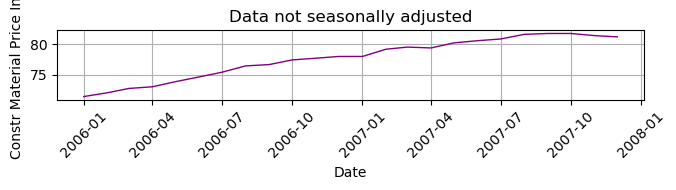

In [112]:
#Visualization of 2 years interval 
plot_time_series_graph(df_9_m.iloc[:24,:], 'purple', 'Data not seasonally adjusted')

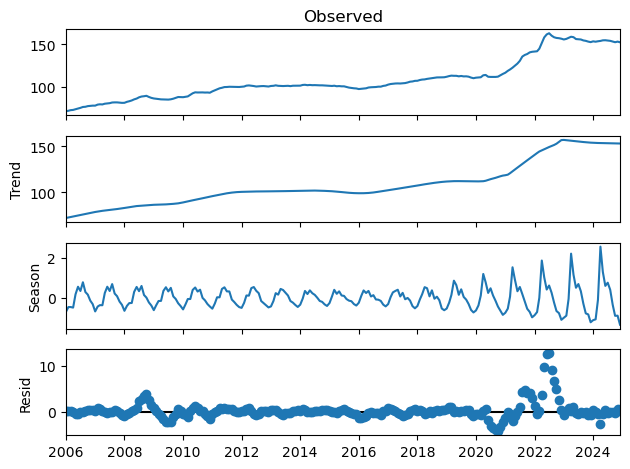

In [113]:
# Perform STL decomposition
# 13 periods for yearly seasonality in monthly data
stl = STL(df_9_m, period=12, seasonal=13, robust=True)
result1 = stl.fit()

# Plot the decomposition
result1.plot()
plt.show()

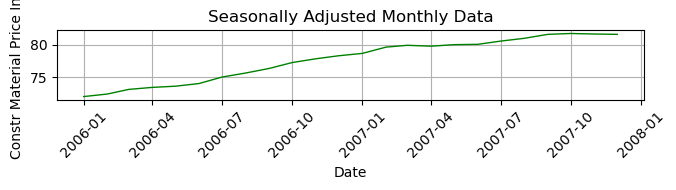

In [114]:
# Extract the seasonally adjusted data
df_9_m_seasonality = result1.seasonal.to_frame()
df_9_m.iloc[:, 0] = df_9_m.iloc[:, 0] - df_9_m_seasonality.iloc[:, 0]
#Visualization of 3 years interval 
plot_time_series_graph(df_9_m.iloc[:24,:], 'green', 'Seasonally Adjusted Monthly Data')

In [115]:
#Creating a quarterly dataframe
df_9_q = make_mean_q_from_m(df_9_m)
df_9_q

,Constr Material Price Index
Date,
2006Q1,72.566487
2006Q2,73.731680
2006Q3,75.698861
2006Q4,77.812278
2007Q1,79.408286
...,...
2023Q4,153.926186
2024Q1,153.850626
2024Q2,152.719934


#### Indicator 10: Number of construction firms

- Source: Office for National Statistics (ONS)
- Frequency: annually
- Coverage: 1997 - 2023
- Release date: 22-Nov-2024
- Next release: unknown

In [116]:
#Extract data from a saved file
df_10 = pd.read_csv('df_10_raw.csv')
df_10.head(10)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,Table 3.1: Construction firms: Number of Firm...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,This worksheet contains one table.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,This table refers to [note 16][note 17][note 1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Some shorthand is used in this table, [x] = un...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Source: Office for National Statistics and Int...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Number of Business' classified to Construction...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Size of Firm,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0
7,0 (sole proprietors),[x],[x],[x],[x],[x],[x],[x],[x],[x],...,40811.0,38711.0,39484.0,39819.0,38888.0,38520.0,36891.0,35352.0,45101.0,37451.0
8,1,86269,87837,88018,87712,77926,71431,70370,71620,73117,...,92926.0,108691.0,123489.0,133472.0,138069.0,144229.0,148584.0,153622.0,157012.0,156153.0
9,2-3,47644,47918,49350,48773,50653,50306,53022,55027,57320,...,66135.0,72128.0,76845.0,82783.0,88297.0,91843.0,94651.0,100218.0,103938.0,103337.0


In [117]:
#Data cleaning from meta-data and empty rows and columns
df_10 = cleaning_meta_data_empty_rows_columns(df_10, 6)
df_10

,Size of Firm,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,0 (sole proprietors),[x],[x],[x],[x],[x],[x],[x],[x],[x],...,40811.0,38711.0,39484.0,39819.0,38888.0,38520.0,36891.0,35352.0,45101.0,37451.0
1,1,86269,87837,88018,87712,77926,71431,70370,71620,73117,...,92926.0,108691.0,123489.0,133472.0,138069.0,144229.0,148584.0,153622.0,157012.0,156153.0
2,2-3,47644,47918,49350,48773,50653,50306,53022,55027,57320,...,66135.0,72128.0,76845.0,82783.0,88297.0,91843.0,94651.0,100218.0,103938.0,103337.0
3,4-7,15737,16391,16969,16584,22455,23963,25704,26865,28435,...,29142.0,30855.0,32339.0,33933.0,35434.0,36071.0,36725.0,38353.0,41044.0,40345.0
4,8-13,3787,3988,4148,3790,8044,9819,10508,10982,11599,...,11455.0,11923.0,12255.0,12665.0,12890.0,12908.0,13269.0,13509.0,14378.0,14283.0
5,14-24,3101,3274,3271,3104,4920,5427,5892,6161,6341,...,6016.0,6203.0,6230.0,6328.0,6444.0,6508.0,6633.0,6648.0,7089.0,7291.0
6,25-34,1176,1201,1332,1201,1782,1809,1932,1985,2037,...,1756.0,1722.0,1842.0,1885.0,1939.0,1905.0,1937.0,1993.0,2068.0,1952.0
7,35-59,1156,1263,1188,1109,999,1782,1821,1906,1928,...,1752.0,1849.0,1848.0,1879.0,1932.0,1918.0,1913.0,1847.0,1860.0,1888.0
8,60-79,396,419,397,364,354,457,583,550,573,...,521.0,511.0,534.0,542.0,556.0,549.0,584.0,602.0,617.0,591.0
9,80-114,296,319,304,271,304,425,451,464,469,...,405.0,436.0,468.0,486.0,474.0,445.0,441.0,441.0,433.0,428.0


In [118]:
#Check info of the dataframe
df_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Size of Firm   15 non-null     object 
 1   1997           15 non-null     object 
 2   1998           15 non-null     object 
 3   1999           15 non-null     object 
 4   2000           15 non-null     object 
 5   2001           15 non-null     object 
 6   2002           15 non-null     object 
 7   2003           15 non-null     object 
 8   2004           15 non-null     object 
 9   2005           15 non-null     object 
 10  2006           15 non-null     object 
 11  2007           15 non-null     object 
 12  2008           15 non-null     object 
 13  2009           15 non-null     object 
 14  2010           15 non-null     float64
 15  2011           15 non-null     float64
 16  2012           15 non-null     float64
 17  2013           15 non-null     float64
 18  2014        

In [119]:
# Exclusion of sole proprietors from consideration.
df_10 = df_10.iloc[1:]
df_10.head(3)

,Size of Firm,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
1,1,86269,87837,88018,87712,77926,71431,70370,71620,73117,...,92926.0,108691.0,123489.0,133472.0,138069.0,144229.0,148584.0,153622.0,157012.0,156153.0
2,2-3,47644,47918,49350,48773,50653,50306,53022,55027,57320,...,66135.0,72128.0,76845.0,82783.0,88297.0,91843.0,94651.0,100218.0,103938.0,103337.0
3,4-7,15737,16391,16969,16584,22455,23963,25704,26865,28435,...,29142.0,30855.0,32339.0,33933.0,35434.0,36071.0,36725.0,38353.0,41044.0,40345.0


In [120]:
#Transpose df
df_10 = df_10.transpose()
df_10 = df_10.reset_index()

df_10.head(3)

,index,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Size of Firm,1,2-3,4-7,8-13,14-24,25-34,35-59,60-79,80-114,115-299,300-599,"600-1,199","1,200 and over",All firms
1,1997,86269,47644,15737,3787,3101,1176,1156,396,296,381,107,60,38,160148
2,1998,87837,47918,16391,3988,3274,1201,1263,419,319,405,125,56,40,163236


In [121]:
df_10.dtypes

index    object
1        object
2        object
3        object
4        object
5        object
6        object
7        object
8        object
9        object
10       object
11       object
12       object
13       object
14       object
dtype: object

In [122]:
# Header correction
columns = ['Date'] + list(df_10.iloc[0, 1:])
df_10.columns = columns
df_10 = df_10.iloc[1:]

df_10.head(3)

,Date,1,2-3,4-7,8-13,14-24,25-34,35-59,60-79,80-114,115-299,300-599,"600-1,199","1,200 and over",All firms
1,1997,86269,47644,15737,3787,3101,1176,1156,396,296,381,107,60,38,160148
2,1998,87837,47918,16391,3988,3274,1201,1263,419,319,405,125,56,40,163236
3,1999,88018,49350,16969,4148,3271,1332,1188,397,304,379,105,58,42,165561


In [123]:
# Converting the Date column to datetime64 format and creating data with a monthly frequency with interpolating data
df_10['Date'] = pd.to_datetime(df_10['Date'], format='%Y')
print(df_10.dtypes)
df_10 = df_10.set_index('Date')
df_10

Date              datetime64[ns]
1                         object
2-3                       object
4-7                       object
8-13                      object
14-24                     object
25-34                     object
35-59                     object
60-79                     object
80-114                    object
115-299                   object
300-599                   object
600-1,199                 object
1,200 and over            object
All firms                 object
dtype: object


,1,2-3,4-7,8-13,14-24,25-34,35-59,60-79,80-114,115-299,300-599,"600-1,199","1,200 and over",All firms
Date,,,,,,,,,,,,,,
1997-01-01,86269,47644,15737,3787,3101,1176,1156,396,296,381,107,60,38,160148
1998-01-01,87837,47918,16391,3988,3274,1201,1263,419,319,405,125,56,40,163236
1999-01-01,88018,49350,16969,4148,3271,1332,1188,397,304,379,105,58,42,165561
2000-01-01,87712,48773,16584,3790,3104,1201,1109,364,271,341,91,51,35,163426
2001-01-01,77926,50653,22455,8044,4920,1782,999,354,304,433,129,68,56,168123
2002-01-01,71431,50306,23963,9819,5427,1809,1782,457,425,520,123,62,57,166181
2003-01-01,70370,53022,25704,10508,5892,1932,1821,583,451,535,135,75,64,171092
2004-01-01,71620,55027,26865,10982,6161,1985,1906,550,464,560,148,75,60,176403
2005-01-01,73117,57320,28435,11599,6341,2037,1928,573,469,556,148,65,56,182644


In [124]:
df_10 = df_10.astype(int)
print(df_10.dtypes)

1                 int64
2-3               int64
4-7               int64
8-13              int64
14-24             int64
25-34             int64
35-59             int64
60-79             int64
80-114            int64
115-299           int64
300-599           int64
600-1,199         int64
1,200 and over    int64
All firms         int64
dtype: object


In [125]:
# Grouping of companies into small (up to 59 employees) , medium (60 - 299 employees) and large (300 and more employees).
small_companies = ['1', '2-3', '4-7', '8-13', '14-24', '25-34']
medium_companies = ['35-59', '60-79', '80-114', '115-299']
large_companies = ['300-599', '600-1,199', '1,200 and over']

#to avoid SettingWithCopyWarning create a copy of df_10:
df_10_1 = df_10.copy()
df_10_1['Small construction companies'] = df_10[small_companies].sum(axis = 1)
df_10_1['Medium construction companies'] = df_10[medium_companies].sum(axis = 1)
df_10_1['Large construction companies'] = df_10[large_companies].sum(axis = 1)
df_10_1['Number of all construction companies'] = df_10[(small_companies + medium_companies + large_companies)].sum(axis = 1)


df_10_1 = df_10_1.drop(columns=(small_companies + medium_companies + large_companies + ['All firms']))
df_10 = df_10_1.copy()
print(df_10.dtypes)
df_10.head(3)

Small construction companies            int64
Medium construction companies           int64
Large construction companies            int64
Number of all construction companies    int64
dtype: object


,Small construction companies,Medium construction companies,Large construction companies,Number of all construction companies
Date,,,,
1997-01-01,157714,2229,205,160148
1998-01-01,160609,2406,221,163236
1999-01-01,163088,2268,205,165561


In [126]:
# Determine the required data interval:
df_10 = df_10.loc[pd.to_datetime('2006-01-01'):pd.to_datetime('2025-03-01'), :]
df_10

,Small construction companies,Medium construction companies,Large construction companies,Number of all construction companies
Date,,,,
2006-01-01,182187,3646,274,186107
2007-01-01,188109,3811,279,192199
2008-01-01,198153,3971,283,202407
2009-01-01,190072,3675,278,194025
2010-01-01,203492,3486,267,207245
2011-01-01,203688,3254,263,207205
2012-01-01,200878,3226,259,204363
2013-01-01,206870,3166,247,210283
2014-01-01,207430,3160,246,210836


In [127]:
# 1.Interpolation between annual points
df_10_q = df_10.copy()
df_10_q = (
    df_10_q
    .resample('QS-JAN').asfreq()
    .interpolate('linear')
)
# 2. Converting into PeriodIndex
df_10_q.index = df_10_q.index.to_period('Q-DEC')
df_10_q.index.name = 'Quarter'

df_10_q.head(3)

,Small construction companies,Medium construction companies,Large construction companies,Number of all construction companies
Quarter,,,,
2006Q1,182187.0,3646.00,274.00,186107.0
2006Q2,183667.5,3687.25,275.25,187630.0
2006Q3,185148.0,3728.50,276.50,189153.0


In [128]:
df_10_q.dtypes

Small construction companies            float64
Medium construction companies           float64
Large construction companies            float64
Number of all construction companies    float64
dtype: object

#### Indicator 11: Number of employees in the construction sector
- Source: Office for National Statistics (ONS)
- Frequency: annually
- Coverage: 1997 - 2023
- Release date: 22-Nov-2024
- Next release: unknown
- Employees by businesses classified to construction  - 3rd quarter each year: thousands

In [129]:
#Extract data from a saved file
df_11 = pd.read_csv('df_11_raw.csv')
df_11.head(10)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,Table 3.4: Construction firms: Total Employees...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,This worksheet contains one table.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,This table refers to [note 16][note 18][note 1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Source: Office for National Statistics and Int...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Employees by businesses classified to Construc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Size of Firm,1997.0,1998.0,1999.0,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,...,2014.0,2015.0,2016.0,2017.0,2018.000,2019.0,2020.0,2021.0,2022.0,2023.0
6,1,77.4,77.4,183.2,185.9,66.5,63.6,82.9,70.0,77.6,...,92.9,108.7,123.5,133.5,138.100,144.2,148.6,153.6,157.0,156.2
7,2-3,145.2,148.3,120.5,142.8,126.4,92.1,99.8,97.4,112.0,...,152.5,163.9,174.2,187.2,199.499,207.1,213.3,225.1,234.3,232.9
8,4-7,77.8,81.2,119.3,116.0,135.0,126.1,133.3,120.3,136.7,...,146.4,154.4,161.4,169.2,176.841,180.2,183.0,190.5,204.3,200.6
9,8-13,39.7,41.6,48.0,45.3,93.7,106.7,112.6,99.9,110.2,...,113.2,116.9,119.9,123.8,125.672,125.5,129.1,131.0,139.2,138.4


In [130]:
#Data cleaning from meta-data and empty rows and columns
df_11 = cleaning_meta_data_empty_rows_columns(df_11, 5)
df_11

,Size of Firm,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,1,77.4,77.4,183.2,185.9,66.5,63.6,82.9,70.0,77.6,...,92.9,108.7,123.5,133.5,138.100,144.2,148.6,153.6,157.0,156.2
1,2-3,145.2,148.3,120.5,142.8,126.4,92.1,99.8,97.4,112.0,...,152.5,163.9,174.2,187.2,199.499,207.1,213.3,225.1,234.3,232.9
2,4-7,77.8,81.2,119.3,116.0,135.0,126.1,133.3,120.3,136.7,...,146.4,154.4,161.4,169.2,176.841,180.2,183.0,190.5,204.3,200.6
3,8-13,39.7,41.6,48.0,45.3,93.7,106.7,112.6,99.9,110.2,...,113.2,116.9,119.9,123.8,125.672,125.5,129.1,131.0,139.2,138.4
4,14-24,56.0,59.5,63.2,65.7,97.9,103.6,104.2,99.7,114.5,...,106.2,109.4,109.9,111.5,113.282,114.1,116.3,116.6,124.3,128.7
5,25-34,34.5,35.1,36.0,40.2,58.6,47.7,56.5,52.8,59.9,...,50.8,50.0,53.4,54.7,56.071,55.4,56.4,58.0,60.2,56.7
6,35-59,51.9,56.6,58.1,53.7,62.6,78.8,82.7,99.5,86.5,...,77.1,81.4,81.4,83.2,85.779,85.3,85.0,81.7,82.4,83.3
7,60-79,27.1,28.8,29.3,28.1,28.8,29.0,37.7,36.0,39.9,...,35.6,35.0,36.5,37.1,37.850,37.6,39.9,41.0,42.1,40.5
8,80-114,28.3,30.9,31.7,29.2,32.2,37.6,45.5,43.8,46.5,...,38.0,40.6,43.4,44.9,44.255,41.5,41.5,41.4,40.8,40.2
9,115-299,68.1,71.1,78.5,68.8,80.9,87.6,100.7,93.4,106.1,...,84.6,87.7,89.2,96.5,98.529,101.2,100.8,94.9,96.6,98.4


In [131]:
#Transpose df
df_11 = df_11.transpose()
df_11 = df_11.reset_index()

# Header correction
columns = ['Date'] + list(df_11.iloc[0, 1:])
df_11.columns = columns
df_11 = df_11.iloc[1:]

#Change data type:
df_11.iloc[:, 1:] = df_11.iloc[:, 1:].astype(float)

df_11.head(3)

,Date,1,2-3,4-7,8-13,14-24,25-34,35-59,60-79,80-114,115-299,300-599,"600-1,199","1,200 and over",All firms
1,1997,77.4,145.2,77.8,39.7,56.0,34.5,51.9,27.1,28.3,68.1,45.5,50.8,76.3,778.5
2,1998,77.4,148.3,81.2,41.6,59.5,35.1,56.6,28.8,30.9,71.1,52.1,49.1,82.0,813.6
3,1999,183.2,120.5,119.3,48.0,63.2,36.0,58.1,29.3,31.7,78.5,47.3,51.6,92.3,958.8


In [132]:
# Converting the Date column to datetime64 format and creating data with a monthly frequency with interpolating data
df_11['Date'] = pd.to_datetime(df_11['Date'], format='%Y')
print(df_11.dtypes)
df_11 = df_11.set_index('Date')
df_11.head(3)

Date              datetime64[ns]
1                         object
2-3                       object
4-7                       object
8-13                      object
14-24                     object
25-34                     object
35-59                     object
60-79                     object
80-114                    object
115-299                   object
300-599                   object
600-1,199                 object
1,200 and over            object
All firms                 object
dtype: object


,1,2-3,4-7,8-13,14-24,25-34,35-59,60-79,80-114,115-299,300-599,"600-1,199","1,200 and over",All firms
Date,,,,,,,,,,,,,,
1997-01-01,77.4,145.2,77.8,39.7,56.0,34.5,51.9,27.1,28.3,68.1,45.5,50.8,76.3,778.5
1998-01-01,77.4,148.3,81.2,41.6,59.5,35.1,56.6,28.8,30.9,71.1,52.1,49.1,82.0,813.6
1999-01-01,183.2,120.5,119.3,48.0,63.2,36.0,58.1,29.3,31.7,78.5,47.3,51.6,92.3,958.8


In [133]:
# Grouping of companies into small (up to 59 employees) , medium (60 - 299 employees) and large (300 and more employees).
# small_companies = ['1', '2-3', '4-7', '8-13', '14-24', '25-34']
# medium_companies = ['35-59', '60-79', '80-114', '115-299']
# large_companies = ['300-599', '600-1,199', '1,200 and over']

df_11_1 = df_11.copy()
df_11_1['Employees - Small construction companies'] = (df_11[small_companies].sum(axis = 1) * 1000).astype(int)
df_11_1['Employees - Medium construction companies'] = (df_11[medium_companies].sum(axis = 1) * 1000).astype(int)
df_11_1['Employees - Large construction companies'] = (df_11[large_companies].sum(axis = 1) * 1000).astype(int)
df_11_1['Employees - All construction companies'] = (df_11[(small_companies + medium_companies + large_companies)].sum(axis = 1) * 1000).astype(int)

df_11_1 = df_11_1.drop(columns=(small_companies + medium_companies + large_companies + ['All firms']))
df_11 = df_11_1.copy()

df_11.head(3)

,Employees - Small construction companies,Employees - Medium construction companies,Employees - Large construction companies,Employees - All construction companies
Date,,,,
1997-01-01,430599,175399,172600,778599
1998-01-01,443100,187400,183200,813700
1999-01-01,570200,197600,191200,959000


In [134]:
# Determine the required data interval:
df_11 = df_11.loc[pd.to_datetime('2006-01-01'):pd.to_datetime('2023-12-01'), :]
df_11

,Employees - Small construction companies,Employees - Medium construction companies,Employees - Large construction companies,Employees - All construction companies
Date,,,,
2006-01-01,632300,289600,293400,1215299
2007-01-01,680600,299299,306400,1286300
2008-01-01,671199,291800,303299,1266299
2009-01-01,606199,241899,266300,1114399
2010-01-01,676700,261000,284500,1222200
2011-01-01,655600,243500,260700,1159800
2012-01-01,652700,238400,263000,1154100
2013-01-01,660000,235800,256000,1151800
2014-01-01,662000,235299,253700,1151000


In [135]:
# 1.Interpolation between annual points
df_11_q = df_11.copy()
df_11_q = (
    df_11_q
    .resample('QS-JAN').asfreq()
    .interpolate('linear')
)
# 2. Converting into PeriodIndex
df_11_q.index = df_11_q.index.to_period('Q-DEC')
df_11_q.index.name = 'Quarter'

df_11_q.head(3)

,Employees - Small construction companies,Employees - Medium construction companies,Employees - Large construction companies,Employees - All construction companies
Quarter,,,,
2006Q1,632300.0,289600.00,293400.0,1215299.00
2006Q2,644375.0,292024.75,296650.0,1233049.25
2006Q3,656450.0,294449.50,299900.0,1250799.50


In [136]:
df_11_q.dtypes

Employees - Small construction companies     float64
Employees - Medium construction companies    float64
Employees - Large construction companies     float64
Employees - All construction companies       float64
dtype: object

#### Indicator 12: Number and value of new construction contracts/orders
- Source: Office for National Statistics (ONS)
- Frequency: annually, quarterly
- Coverage: 1964 Q1 - 2025 Q1
- Release date: 15-May-2025
- Next release: 14-Aug-2025
- Seasonally adjusted data
- £ million

In [137]:
#Extract data from a saved file
df_12 = pd.read_csv('df_12_raw.csv')
df_12.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11
0,Table 1: New Orders for construction: volume s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,This worksheet contains one table. Some cells ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Source: Office for National Statistics and Bar...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022=100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Time period,New housing\npublic,New housing\nprivate,All \nnew housing,Other new work\ninfrastructure,Other new work\nexcluding infrastructure,Private\nindustrial,Private\ncommercial,All\nother work,All\nnew work,Period on period growths (%),Period on same period one year ago growths (%)
5,1964,853.7,258.5,316.8,NaN,339.7,151.6,99.3,121.4,177.2,NaN,NaN
6,1965,916.6,237.1,303.7,NaN,320.3,156.7,82.1,112.3,167,-0.058,NaN
7,1966,960.5,194.6,269.7,NaN,324.5,149.2,73.5,108.3,154.4,-0.076,NaN
8,1967,1204,230.4,325.9,NaN,416.5,157.1,61,119.7,178.6,0.157,NaN
9,1968,1049.6,193.9,277.8,NaN,370.9,160.4,66.4,115,161.5,-0.096,NaN


In [138]:
#Data cleaning from meta-data and empty rows and columns
df_12 = cleaning_meta_data_empty_rows_columns(df_12, 4)
df_12

,Time period,New housing\npublic,New housing\nprivate,All \nnew housing,Other new work\ninfrastructure,Other new work\nexcluding infrastructure,Private\nindustrial,Private\ncommercial,All\nother work,All\nnew work,Period on period growths (%),Period on same period one year ago growths (%)
0,1964,853.7,258.5,316.8,NaN,339.7,151.6,99.3,121.4,177.2,NaN,NaN
1,1965,916.6,237.1,303.7,NaN,320.3,156.7,82.1,112.3,167,-0.058,NaN
2,1966,960.5,194.6,269.7,NaN,324.5,149.2,73.5,108.3,154.4,-0.076,NaN
3,1967,1204,230.4,325.9,NaN,416.5,157.1,61,119.7,178.6,0.157,NaN
4,1968,1049.6,193.9,277.8,NaN,370.9,160.4,66.4,115,161.5,-0.096,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
301,Jan to Mar 2024,59.8,77.2,75.5,68.9,113.8,71.4,90.8,85.4,82.6,0.143,-0.029
302,Apr to Jun 2024,124.9,87.2,90.9,89.1,129.6,88.4,103.8,101.4,98.4,0.192,0.283
303,Jul to Sep 2024,73.2,55,56.8,90.7,89.4,63.2,81.7,82.1,74.9,-0.239,-0.097
304,Oct to Dec 2024,75.2,68.6,69.2,62.9,92.1,51,82.2,73.3,72.1,-0.037,-0.002


In [139]:
# Determine the required data interval:
print(df_12[df_12['Time period'] == 'Jan to Mar 2006'])
print(df_12[df_12['Time period'] == 'Jan to Mar 2025'])

         Time period New housing\npublic New housing\nprivate  \
229  Jan to Mar 2006               215.3                117.6   

    All \nnew housing Other new work\ninfrastructure  \
229             127.1                           41.9   

    Other new work\nexcluding infrastructure Private\nindustrial  \
229                                    169.8               111.2   

    Private\ncommercial All\nother work All\nnew work  \
229               206.1           140.2         136.5   

    Period on period growths (%)  \
229                        0.023   

    Period on same period one year ago growths (%)  
229                                          0.113  
         Time period New housing\npublic New housing\nprivate  \
305  Jan to Mar 2025                80.5                 63.9   

    All \nnew housing Other new work\ninfrastructure  \
305              65.5                          143.4   

    Other new work\nexcluding infrastructure Private\nindustrial  \
305          

In [140]:
#Extracting the required data interval:
df_12 = df_12.iloc[229:306].reset_index(drop=True)
df_12.head(3)

,Time period,New housing\npublic,New housing\nprivate,All \nnew housing,Other new work\ninfrastructure,Other new work\nexcluding infrastructure,Private\nindustrial,Private\ncommercial,All\nother work,All\nnew work,Period on period growths (%),Period on same period one year ago growths (%)
0,Jan to Mar 2006,215.3,117.6,127.1,41.9,169.8,111.2,206.1,140.2,136.5,0.023,0.113
1,Apr to Jun 2006,210.2,126.6,134.8,53,140.3,98.3,233,146.7,143.3,0.05,0.107
2,Jul to Sep 2006,281,119.3,135.1,55.4,155,111.5,208.8,142.4,140.3,-0.021,0.064


In [141]:
#Dropping unnecessary columns
df_12 = df_12.drop(columns = ['All \nnew housing', 'All\nother work', 'Period on period growths (%)', 'Period on same period one year ago growths (%)', 'All\nnew work'])
df_12.head(3)

,Time period,New housing\npublic,New housing\nprivate,Other new work\ninfrastructure,Other new work\nexcluding infrastructure,Private\nindustrial,Private\ncommercial
0,Jan to Mar 2006,215.3,117.6,41.9,169.8,111.2,206.1
1,Apr to Jun 2006,210.2,126.6,53,140.3,98.3,233
2,Jul to Sep 2006,281,119.3,55.4,155,111.5,208.8


In [142]:
#Setting new column names
columns = ['Date', 'New Contracts - Public Housing', 'New Contracts - Private Housing', 'New Contracts - Infrastructure', 'New contracts - Other', 'New Contracts - Private Industrial', 'New Contracts - Private Commercial']
df_12.columns = columns
df_12.head(3)

,Date,New Contracts - Public Housing,New Contracts - Private Housing,New Contracts - Infrastructure,New contracts - Other,New Contracts - Private Industrial,New Contracts - Private Commercial
0,Jan to Mar 2006,215.3,117.6,41.9,169.8,111.2,206.1
1,Apr to Jun 2006,210.2,126.6,53,140.3,98.3,233
2,Jul to Sep 2006,281,119.3,55.4,155,111.5,208.8


In [143]:
df_12.dtypes

Date                                  object
New Contracts - Public Housing        object
New Contracts - Private Housing       object
New Contracts - Infrastructure        object
New contracts - Other                 object
New Contracts - Private Industrial    object
New Contracts - Private Commercial    object
dtype: object

In [144]:
# Convert 'Date' to the first month of the quarter
df_12[['Month', 'Year']] = df_12['Date'].str.extract(r'(\w+)\s+to\s+\w+\s+(\d{4})')  # Extract start month and year
df_12['Date'] = pd.to_datetime(df_12['Year'] + ' ' + df_12['Month'], format='%Y %b')  # Combine and convert

# Drop helper columns
df_12 = df_12.drop(columns=['Month', 'Year'])

#  set index and convert to quarterly PeriodIndex (Q1)
df_12 = (df_12
       .set_index('Date')
       .sort_index())
df_12.index = df_12.index.to_period('Q-DEC')   # calendar-year quarters
df_12.index.name = 'Quarter'

df_12.head(3)

,New Contracts - Public Housing,New Contracts - Private Housing,New Contracts - Infrastructure,New contracts - Other,New Contracts - Private Industrial,New Contracts - Private Commercial
Quarter,,,,,,
2006Q1,215.3,117.6,41.9,169.8,111.2,206.1
2006Q2,210.2,126.6,53,140.3,98.3,233
2006Q3,281,119.3,55.4,155,111.5,208.8


In [145]:
df_12 = df_12.astype(float)
df_12.dtypes

New Contracts - Public Housing        float64
New Contracts - Private Housing       float64
New Contracts - Infrastructure        float64
New contracts - Other                 float64
New Contracts - Private Industrial    float64
New Contracts - Private Commercial    float64
dtype: object

In [146]:
df_12_q = df_12.copy()

#### Indicator 13: UK Workforce Jobs SA : F Construction  (thousands)
- Source: Office for National Statistics (ONS)
- Frequency: quarterly, annualy
- Coverage: 1978 Q2 - 2025 Q1
- Release date: 12-Aug-2025
- Next release: 16-Aug-2025
- Seasonally adjusted data

In [147]:
#Extract data from a saved file
df_13 = pd.read_csv('df_13_raw.csv')
df_13.head(3)

,Date,Workforce Jobs (thousands)
0,1978,1887
1,1979,1931
2,1980,1962


In [148]:
# Determine the required data interval:
print(df_13[df_13['Date'] == '2006 Q1'])
print(df_13[df_13['Date'] == '2025 Q1'])

        Date  Workforce Jobs (thousands)
158  2006 Q1                        2256
        Date  Workforce Jobs (thousands)
234  2025 Q1                        2249


In [149]:
#Extracting the required data interval:
df_13 = df_13.iloc[158:235].reset_index(drop=True)
df_13.head(3)

,Date,Workforce Jobs (thousands)
0,2006 Q1,2256
1,2006 Q2,2269
2,2006 Q3,2281


In [150]:
# 1. Build a quarterly PeriodIndex from "YYYY Qn"
new_index = pd.PeriodIndex(
    df_13['Date'].astype(str).str.replace(r'\s+', '', regex=True),  
    freq='Q-DEC' 
)

# 2. Set index, coerce to numeric, sort
col = 'Workforce Jobs (thousands)'
df_13 = (
    df_13.drop(columns='Date')
           .assign(**{col: pd.to_numeric(df_13[col], errors='coerce')})
           .set_index(new_index)
           .sort_index()
)
df_13.index.name = 'Quarter'
df_13_q = df_13.copy()
df_13_q

,Workforce Jobs (thousands)
Quarter,
2006Q1,2256
2006Q2,2269
2006Q3,2281
2006Q4,2342
2007Q1,2318
...,...
2024Q1,2232
2024Q2,2155
2024Q3,2220


## 2. Merging all data sets into 4 dataframes : df_q_eda, df_q_eda_add, df_m_model, df_q_model

#### 2.1 Quarterly dataframe (2006 Q1 - 2025 Q1) for Exploratory Data Analysis (EDA)

In [151]:
# Merging full quarterly datasets (2006 Q1 - 2025 Q1) for Exploratory Data Analysis (EDA)

df_q_eda = pd.concat([df_1_q, df_2_q, df_3_q, df_4_q, df_5_q, df_6_q, df_7_q, df_8_q, df_12_q, df_13_q], axis=1, join='inner')
df_q_eda

,CPIH,Production GDP,Services GDP,"Employment rate, %","BoE Rate, %",EUR/GBP,USD/GBP,"Business Investment, % change","Govt Expenditure, £m",Construction output,New Contracts - Public Housing,New Contracts - Private Housing,New Contracts - Infrastructure,New contracts - Other,New Contracts - Private Industrial,New Contracts - Private Commercial,Workforce Jobs (thousands)
2006Q1,80.437510,107.624333,76.785467,72.9,4.500000,1.457300,1.752767,5.1,3712.618937,83.7,215.3,117.6,41.9,169.8,111.2,206.1,2256
2006Q2,80.972408,109.472000,76.816567,72.8,4.500000,1.453300,1.827167,-3.9,9101.255103,84.3,210.2,126.6,53.0,140.3,98.3,233.0,2269
2006Q3,81.785671,109.874733,76.934333,72.8,4.666667,1.471200,1.874600,7.7,6530.808830,84.6,281.0,119.3,55.4,155.0,111.5,208.8,2281
2006Q4,82.242322,109.425633,77.487767,72.7,4.916667,1.485433,1.916900,0.2,6204.016512,86.1,195.8,118.5,54.2,159.5,99.7,183.7,2342
2007Q1,82.653351,108.405100,78.714033,72.5,5.250000,1.491700,1.954633,4.8,5335.053191,87.2,261.7,120.2,68.3,161.6,106.3,196.4,2318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024Q1,131.064092,98.713400,101.366533,74.5,5.250000,1.168267,1.267967,-0.2,20402.788656,102.1,59.8,77.2,68.9,113.8,71.4,90.8,2232
2024Q2,132.426323,98.220433,101.979167,74.6,5.250000,1.172233,1.261867,1.8,18168.030920,102.3,124.9,87.2,89.1,129.6,88.4,103.8,2155
2024Q3,133.214105,97.884200,101.999667,74.9,5.083333,1.183467,1.300433,2.2,18262.932977,102.7,73.2,55.0,90.7,89.4,63.2,81.7,2220
2024Q4,134.680024,97.448333,102.117067,75.0,4.833333,1.201633,1.281400,-1.9,21548.637408,103.0,75.2,68.6,62.9,92.1,51.0,82.2,2229


In [152]:
df_q_eda.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 77 entries, 2006Q1 to 2025Q1
Freq: Q-DEC
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   CPIH                                77 non-null     float64
 1   Production GDP                      77 non-null     float64
 2   Services GDP                        77 non-null     float64
 3   Employment rate, %                  77 non-null     float64
 4   BoE Rate, %                         77 non-null     float64
 5   EUR/GBP                             77 non-null     float64
 6   USD/GBP                             77 non-null     float64
 7   Business Investment, % change       77 non-null     float64
 8   Govt Expenditure, £m                77 non-null     float64
 9   Construction output                 77 non-null     float64
 10  New Contracts - Public Housing      77 non-null     float64
 11  New Contracts - Private H

#### 2.2 Additional dataframe with incomplete quarterly datasets for individual consideration in Exploratory Data Analysis (EDA)

In [153]:
# Merging additional incomplete quarterly datasets for individual consideration in Exploratory Data Analysis (EDA)

df_q_eda_add = pd.concat([df_9_q, df_10_q, df_11_q], axis=1, join='outer')
df_q_eda_add

,Constr Material Price Index,Small construction companies,Medium construction companies,Large construction companies,Number of all construction companies,Employees - Small construction companies,Employees - Medium construction companies,Employees - Large construction companies,Employees - All construction companies
2006Q1,72.566487,182187.0,3646.00,274.00,186107.0,632300.0,289600.00,293400.0,1215299.00
2006Q2,73.731680,183667.5,3687.25,275.25,187630.0,644375.0,292024.75,296650.0,1233049.25
2006Q3,75.698861,185148.0,3728.50,276.50,189153.0,656450.0,294449.50,299900.0,1250799.50
2006Q4,77.812278,186628.5,3769.75,277.75,190676.0,668525.0,296874.25,303150.0,1268549.75
2007Q1,79.408286,188109.0,3811.00,279.00,192199.0,680600.0,299299.00,306400.0,1286300.00
...,...,...,...,...,...,...,...,...,...
2023Q4,153.926186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024Q1,153.850626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024Q2,152.719934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024Q3,153.358025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [154]:
df_q_eda_add.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 76 entries, 2006Q1 to 2024Q4
Freq: Q-DEC
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Constr Material Price Index                76 non-null     float64
 1   Small construction companies               69 non-null     float64
 2   Medium construction companies              69 non-null     float64
 3   Large construction companies               69 non-null     float64
 4   Number of all construction companies       69 non-null     float64
 5   Employees - Small construction companies   69 non-null     float64
 6   Employees - Medium construction companies  69 non-null     float64
 7   Employees - Large construction companies   69 non-null     float64
 8   Employees - All construction companies     69 non-null     float64
dtypes: float64(9)
memory usage: 5.9 KB


#### 2.3 Monthly dataframe (Jul 2014 - Dec 2024) for Modeling

In [155]:
# Merging all monthly datasets with a common date window (Jul 2014 - Dec 2024) for Modeling

df_m_model = pd.concat([df_1_m, df_2_m, df_4_m, df_5_m, df_7_m, df_8_m, df_9_m], axis=1, join='inner')
df_m_model

,CPIH,Production GDP,Services GDP,"BoE Rate, %",EUR/GBP,USD/GBP,"Govt Expenditure, £m",Construction output,Constr Material Price Index
Date,,,,,,,,,
2010-01-01,89.152185,95.7383,78.2863,0.50,1.1327,1.6162,3257.865459,74.1,88.445678
2010-02-01,89.134777,97.0504,79.4659,0.50,1.1415,1.5615,4007.474986,77.3,88.649877
2010-03-01,89.456694,98.1040,80.1110,0.50,1.1092,1.5053,3897.392720,77.7,88.851144
2010-04-01,89.700987,96.4009,79.9149,0.50,1.1436,1.5340,2916.291169,78.8,90.689599
2010-05-01,89.841764,96.3176,80.4956,0.50,1.1685,1.4627,3319.885018,80.3,92.069932
...,...,...,...,...,...,...,...,...,...
2024-08-01,133.513259,98.1546,102.0414,5.00,1.1741,1.2933,6433.478974,103.0,153.395334
2024-09-01,133.761491,98.0284,102.0096,5.00,1.1903,1.3217,5840.833757,102.8,153.337200
2024-10-01,134.166000,97.3352,101.8881,5.00,1.1972,1.3045,6415.304108,102.7,153.083546


#### 2.4 Quarterly dataframe (2006 Q1 - 2024 Q4) for Modeling

In [156]:
# Merging quarterly datasets with a common date window (2006 Q1 - 2024 Q4) for Modeling

df_q_model = pd.concat([df_1_q, df_2_q, df_3_q, df_4_q, df_5_q, df_6_q, df_7_q, df_8_q, df_9_q, df_12_q, df_13_q], axis=1, join='inner')
df_q_model

,CPIH,Production GDP,Services GDP,"Employment rate, %","BoE Rate, %",EUR/GBP,USD/GBP,"Business Investment, % change","Govt Expenditure, £m",Construction output,Constr Material Price Index,New Contracts - Public Housing,New Contracts - Private Housing,New Contracts - Infrastructure,New contracts - Other,New Contracts - Private Industrial,New Contracts - Private Commercial,Workforce Jobs (thousands)
2006Q1,80.437510,107.624333,76.785467,72.9,4.500000,1.457300,1.752767,5.1,3712.618937,83.7,72.566487,215.3,117.6,41.9,169.8,111.2,206.1,2256
2006Q2,80.972408,109.472000,76.816567,72.8,4.500000,1.453300,1.827167,-3.9,9101.255103,84.3,73.731680,210.2,126.6,53.0,140.3,98.3,233.0,2269
2006Q3,81.785671,109.874733,76.934333,72.8,4.666667,1.471200,1.874600,7.7,6530.808830,84.6,75.698861,281.0,119.3,55.4,155.0,111.5,208.8,2281
2006Q4,82.242322,109.425633,77.487767,72.7,4.916667,1.485433,1.916900,0.2,6204.016512,86.1,77.812278,195.8,118.5,54.2,159.5,99.7,183.7,2342
2007Q1,82.653351,108.405100,78.714033,72.5,5.250000,1.491700,1.954633,4.8,5335.053191,87.2,79.408286,261.7,120.2,68.3,161.6,106.3,196.4,2318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023Q4,130.229424,98.506833,100.260767,74.9,5.250000,1.153967,1.241700,1.8,17063.540767,102.1,153.926186,132.6,71.6,66.9,85.0,58.3,71.3,2213
2024Q1,131.064092,98.713400,101.366533,74.5,5.250000,1.168267,1.267967,-0.2,20402.788656,102.1,153.850626,59.8,77.2,68.9,113.8,71.4,90.8,2232
2024Q2,132.426323,98.220433,101.979167,74.6,5.250000,1.172233,1.261867,1.8,18168.030920,102.3,152.719934,124.9,87.2,89.1,129.6,88.4,103.8,2155
2024Q3,133.214105,97.884200,101.999667,74.9,5.083333,1.183467,1.300433,2.2,18262.932977,102.7,153.358025,73.2,55.0,90.7,89.4,63.2,81.7,2220


## 3. Data normalization for Exploratory Data Analysis EDA

In [157]:
# Select numerical columns
numerical_columns = df_q_eda.columns
numerical_columns_add = df_q_eda_add.columns


# Create dictionaries to store normalized columns
normalized_cols = {}
normalized_cols_add = {}


# Calculate normalized values for each column
for column in numerical_columns:
    # Min-Max Normalization (0 to 1)
    normalized_cols[column] = (df_q_eda[column] - df_q_eda[column].min()) / (df_q_eda[column].max() - df_q_eda[column].min())

for column in numerical_columns_add:
    # Min-Max Normalization (0 to 1)
    normalized_cols_add[column] = (df_q_eda_add[column] - df_q_eda_add[column].min()) / (df_q_eda_add[column].max() - df_q_eda_add[column].min())


# Convert dictionaries to DataFrames
df_q_eda_norm = pd.DataFrame(normalized_cols, index=df_q_eda.index)
df_q_eda_norm_add = pd.DataFrame(normalized_cols_add, index=df_q_eda_add.index)

df_q_eda_norm

,CPIH,Production GDP,Services GDP,"Employment rate, %","BoE Rate, %",EUR/GBP,USD/GBP,"Business Investment, % change","Govt Expenditure, £m",Construction output,New Contracts - Public Housing,New Contracts - Private Housing,New Contracts - Infrastructure,New contracts - Other,New Contracts - Private Industrial,New Contracts - Private Commercial,Workforce Jobs (thousands)
2006Q1,0.000000,0.742881,0.067262,0.444444,0.778761,0.911802,0.664751,0.783871,0.000000,0.534442,0.689325,0.889251,0.000000,0.510917,0.784703,0.856457,0.643293
2006Q2,0.009652,0.819657,0.068376,0.428571,0.778761,0.901547,0.750278,0.493548,0.248220,0.548694,0.667102,0.986971,0.047721,0.367783,0.662890,1.000000,0.682927
2006Q3,0.024326,0.836392,0.072598,0.428571,0.808260,0.947440,0.804805,0.867742,0.129816,0.555819,0.975599,0.907709,0.058040,0.439107,0.787535,0.870864,0.719512
2006Q4,0.032566,0.817731,0.092435,0.412698,0.852507,0.983933,0.853431,0.625806,0.114763,0.591449,0.604357,0.899023,0.052880,0.460941,0.676110,0.736926,0.905488
2007Q1,0.039982,0.775324,0.136391,0.380952,0.911504,1.000000,0.896808,0.774194,0.074735,0.617577,0.891503,0.917481,0.113500,0.471131,0.738432,0.804696,0.832317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024Q1,0.913496,0.372606,0.948366,0.698413,0.911504,0.170755,0.107445,0.612903,0.768809,0.971496,0.011765,0.450597,0.116079,0.239204,0.408876,0.241195,0.570122
2024Q2,0.938076,0.352121,0.970325,0.714286,0.911504,0.180925,0.100433,0.677419,0.665868,0.976247,0.295425,0.559175,0.202923,0.315866,0.569405,0.310566,0.335366
2024Q3,0.952290,0.338150,0.971060,0.761905,0.882006,0.209726,0.144768,0.690323,0.670240,0.985748,0.070153,0.209555,0.209802,0.120815,0.331445,0.192636,0.533537
2024Q4,0.978741,0.320038,0.975268,0.777778,0.837758,0.256303,0.122888,0.558065,0.821591,0.992874,0.078867,0.357220,0.090284,0.133916,0.216242,0.195304,0.560976


In [158]:
df_q_eda_norm_add

,Constr Material Price Index,Small construction companies,Medium construction companies,Large construction companies,Number of all construction companies,Employees - Small construction companies,Employees - Medium construction companies,Employees - Large construction companies,Employees - All construction companies
2006Q1,0.000000,0.000000,0.599260,0.812500,0.000000,0.083363,0.848453,0.753321,0.310652
2006Q2,0.013329,0.010328,0.650123,0.838542,0.010641,0.121929,0.886340,0.814991,0.365301
2006Q3,0.035833,0.020657,0.700986,0.864583,0.021282,0.160495,0.924227,0.876660,0.419951
2006Q4,0.060009,0.030985,0.751850,0.890625,0.031923,0.199060,0.962113,0.938330,0.474601
2007Q1,0.078267,0.041314,0.802713,0.916667,0.042564,0.237626,1.000000,1.000000,0.529250
...,...,...,...,...,...,...,...,...,...
2023Q4,0.930713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024Q1,0.929849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024Q2,0.916914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024Q3,0.924214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. Data differentiation for Modeling

## Monthly Dataset

In [159]:
log_cols = [
    'CPIH', 'Production GDP', 'Services GDP',
    'EUR/GBP', 'USD/GBP',
    'Construction output', 'Constr Material Price Index',
    # include Payrolled employees if present in df_m_model:
    *([ 'Payrolled employees' ] if 'Payrolled employees' in df_m_model.columns else [])
]

diff_cols = [
    'BoE Rate, %',     # policy rate: percentage-point change
    'Govt Expenditure, £m'  # monthly SA flow; pp-change not meaningful; keep plain diff
]

keep_cols = []  # monthly has no "already % change" variables

# Build transforms
df_m_log_diff  = np.log(df_m_model[log_cols]).diff(1) if log_cols else pd.DataFrame(index=df_m_model.index)
df_m_plain_diff = df_m_model[diff_cols].diff(1)        if diff_cols else pd.DataFrame(index=df_m_model.index)

df_m_model_diff = pd.concat([df_m_log_diff, df_m_plain_diff, df_m_model[keep_cols]], axis=1).dropna()

#Check if all data is stationary after first differencing
for i in range(df_m_model_diff.shape[1]):
    result = adfuller(df_m_model_diff.iloc[:, i].dropna())
    if result[1] > 0.05:
        print('Non-stationary data: ',df_m_model_diff.columns[i], result[1])

Non-stationary data:  CPIH 0.15445359687249466
Non-stationary data:  Constr Material Price Index 0.17943968862851217
Non-stationary data:  BoE Rate, % 0.19244559506037218


## MONTHLY (handling non-stationary data)
#### M1) Build monthly transforms (stationary)

In [160]:
df_m_model = df_m_model.sort_index()

# 1) log-diff for positive index/level series
log_m_cols = [
    'Production GDP','Services GDP','EUR/GBP','USD/GBP',
    'Construction output','Constr Material Price Index'
]
log_m_cols = [c for c in log_m_cols if c in df_m_model.columns]
m_logdiff = np.log(df_m_model[log_m_cols]).diff(1) if log_m_cols else pd.DataFrame(index=df_m_model.index)

# 2) CPIH as YoY (Δ12 log)
cpi_m_yoy = np.log(df_m_model['CPIH']).diff(12).rename('CPIH_yoy') if 'CPIH' in df_m_model.columns else None

# 3) plain diffs for rates/flows
diff_m_cols = [c for c in ['Govt Expenditure, £m'] if c in df_m_model.columns]
m_diff = df_m_model[diff_m_cols].diff(1) if diff_m_cols else pd.DataFrame(index=df_m_model.index)

# 4) keep as-is changes
keep_m_cols = [c for c in ['BoE Rate, %'] if c in df_m_model.columns]
m_keep = df_m_model[keep_m_cols] if keep_m_cols else pd.DataFrame(index=df_m_model.index)

# --- Make CPIH_yoy first ---
parts = []
if cpi_m_yoy is not None:
    parts.append(cpi_m_yoy.to_frame())     # CPIH_yoy first
parts += [m_logdiff, m_diff, m_keep]

df_m_model_diff = pd.concat(parts, axis=1).dropna().astype('float64')



#### M2) Minimal monthly dummies (just enough to pass tests)

In [161]:
# Build D_m with only the CPIH regime TCs (slow fade). No other events needed for *stationarity*.

D_m = pd.DataFrame(index=df_m_model_diff.index)

def _add_tc_m(D, name, start, delta=0.95):
    idx = D.index
    pidx = (idx.to_period('M') if not isinstance(idx, pd.PeriodIndex) else idx.asfreq('M'))
    s = pd.Period(pd.to_datetime(start), 'M')
    mask = np.asarray(pidx >= s, dtype=bool)
    k = np.zeros(len(pidx), int); k[mask] = np.arange(mask.sum())
    D[name] = np.where(mask, float(delta)**k, 0.0)

# Energy-driven CPIH regime (three overlapping TCs)
_add_tc_m(D_m, 'CPIH_TC_2021-09_d95', '2021-09-01', 0.95)
_add_tc_m(D_m, 'CPIH_TC_2022-04_d95', '2022-04-01', 0.95)
_add_tc_m(D_m, 'CPIH_TC_2023-07_d95', '2023-07-01', 0.95)

#### M3) Monthly residual stationarity tests (ADF + KPSS)

In [162]:
def ur_on_resid_clean(y, D):
    y = pd.to_numeric(y, errors='coerce').dropna()
    X = sm.add_constant(D.reindex(y.index).fillna(0))
    u = sm.OLS(y, X).fit().resid
    adf_p = adfuller(u, regression='c', autolag='AIC')[1]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", InterpolationWarning)
        k_stat, k_p, _, crit = kpss(u, regression='c', nlags='auto')
    kpss_ok = (k_stat < float(crit['10%']))
    return adf_p, ('>0.10' if kpss_ok else f'{k_p:.3f}'), (adf_p<0.05) and kpss_ok

rows=[]
for c in df_m_model_diff.columns:
    if c=='BoE Rate, %':  # policy impulses: skip test, keep for modeling
        rows.append((c, '—', '—', True))
        continue
    adf_p, kpss_p, ok = ur_on_resid_clean(df_m_model_diff[c], D_m)
    rows.append((c, f'{adf_p:.3g}', kpss_p, ok))
monthly_results = pd.DataFrame(rows, columns=['series','ADF p','KPSS p','PASS']).set_index('series')
monthly_results

,ADF p,KPSS p,PASS
series,,,
CPIH_yoy,0.0231,>0.10,True
Production GDP,2.22e-11,>0.10,True
Services GDP,1.88e-14,>0.10,True
EUR/GBP,7.56e-21,>0.10,True
USD/GBP,3.36e-19,>0.10,True
Construction output,2.03e-17,>0.10,True
Constr Material Price Index,1.72e-09,>0.10,True
"Govt Expenditure, £m",1.28e-17,>0.10,True
"BoE Rate, %",—,—,True


In [163]:
D_m_cols = list(D_m.columns)

## Quarterly Dataset

In [164]:
log_cols = [
    'CPIH', 'Production GDP', 'Services GDP',
    'EUR/GBP', 'USD/GBP',
    'Construction output', 'Constr Material Price Index',
    'New Contracts - Public Housing', 'New Contracts - Private Housing',
    'New Contracts - Infrastructure', 'New contracts - Other',
    'New Contracts - Private Industrial', 'New Contracts - Private Commercial',
    'Workforce Jobs (thousands)'
]

diff_cols = [
    'Employment rate, %',  # percentage-point change
    'BoE Rate, %',         # percentage-point change
    'Govt Expenditure, £m' # Δ £m QoQ (after monthly SA→quarterly sum)
]

keep_cols = [
    'Business Investment, % change'  # already a % change; carry unchanged
]

df_q_log_diff   = np.log(df_q_model[log_cols]).diff(1) if log_cols else pd.DataFrame(index=df_q_model.index)
df_q_plain_diff = df_q_model[diff_cols].diff(1)         if diff_cols else pd.DataFrame(index=df_q_model.index)

df_q_model_diff = pd.concat([df_q_log_diff, df_q_plain_diff, df_q_model[keep_cols]], axis=1).dropna()

#Check if all data is stationary after first differencing
for i in range(df_q_model_diff.shape[1]):
    result = adfuller(df_q_model_diff.iloc[:, i].dropna())
    if result[1] > 0.05:
        print('Non-stationary data: ',df_q_model_diff.columns[i], result[1])

df_q_model_diff.head(3)

Non-stationary data:  CPIH 0.6283219060251273
Non-stationary data:  New Contracts - Private Commercial 0.13401675103765148
Non-stationary data:  Employment rate, % 0.18570375426365582


,CPIH,Production GDP,Services GDP,EUR/GBP,USD/GBP,Construction output,Constr Material Price Index,New Contracts - Public Housing,New Contracts - Private Housing,New Contracts - Infrastructure,New contracts - Other,New Contracts - Private Industrial,New Contracts - Private Commercial,Workforce Jobs (thousands),"Employment rate, %","BoE Rate, %","Govt Expenditure, £m","Business Investment, % change"
2006Q2,0.006628,0.017022,0.000405,-0.002749,0.041571,0.007143,0.015929,-0.023973,0.073743,0.235006,-0.190838,-0.123306,0.122677,0.005746,-0.1,0.000000,5388.636166,-3.9
2006Q3,0.009994,0.003672,0.001532,0.012242,0.025629,0.003552,0.026331,0.290295,-0.059391,0.044288,0.099642,0.126001,-0.109662,0.005275,0.0,0.166667,-2570.446273,7.7
2006Q4,0.005568,-0.004096,0.007168,0.009628,0.022314,0.017575,0.027536,-0.361261,-0.006728,-0.021899,0.028619,-0.111859,-0.128073,0.026391,-0.1,0.250000,-326.792318,0.2


## QUARTERLY (handling non-stationary data)
#### Q1) Build quarterly transforms (stationary)

In [165]:
# QUARTERLY: make series stationary
q = df_q_model.copy()

# Q-DEC PeriodIndex (Q1 = Jan–Mar), numeric, sorted
q.index = (q.index.to_period('Q-DEC')
           if not isinstance(q.index, pd.PeriodIndex)
           else q.index.asfreq('Q-DEC'))
q = q.apply(pd.to_numeric, errors='coerce').sort_index()

# 1) QoQ log-diff for positive level/index series
log_cols = [c for c in [
    'Production GDP','Services GDP','EUR/GBP','USD/GBP',
    'Construction output','Constr Material Price Index',
    'New Contracts - Public Housing','New Contracts - Private Housing',
    'New Contracts - Infrastructure','New contracts - Other',
    'New Contracts - Private Industrial','New Contracts - Private Commercial',
    'Workforce Jobs (thousands)'] if c in q.columns]
q_log1 = np.log(q[log_cols]).diff(1) if log_cols else pd.DataFrame(index=q.index)

# 2) CPIH as YoY log change (Δ4)
parts = [q_log1]
if 'CPIH' in q.columns:
    parts.append(np.log(q['CPIH']).diff(4).rename('CPIH_yoy').to_frame())

# 3) Plain diffs for rates/flows
diff_cols = [c for c in ['BoE Rate, %','Govt Expenditure, £m'] if c in q.columns]
parts.append(q[diff_cols].diff(1) if diff_cols else pd.DataFrame(index=q.index))

# 4) Employment rate: logit Δ1 (QoQ) for stationarity
if 'Employment rate, %' in q.columns:
    emp01 = (q['Employment rate, %']/100).clip(1e-6, 1-1e-6)
    parts.append(np.log(emp01/(1-emp01)).diff(1).rename('Employment rate_logit_d1').to_frame())

# 5) Keep already-change series
keep_cols = [c for c in ['Business Investment, % change'] if c in q.columns]
if keep_cols: parts.append(q[keep_cols])

# Combine & clean
df_q_model_diff = pd.concat(parts, axis=1).dropna().astype('float64')
df_q_model_diff = df_q_model_diff[['CPIH_yoy', 'Production GDP', 'BoE Rate, %', 'Services GDP', 'EUR/GBP', 'USD/GBP', 
                                   'Govt Expenditure, £m', 'Employment rate_logit_d1', 'Business Investment, % change',
                                   'Construction output', 'Constr Material Price Index', 'Workforce Jobs (thousands)',
                                   'New Contracts - Private Housing', 'New Contracts - Private Commercial',
                                   'New Contracts - Private Industrial', 
                                   'New Contracts - Public Housing', 'New Contracts - Infrastructure', 'New contracts - Other',
                                  ]]

#### Q2) Minimal quarterly dummies (just enough to pass tests)

In [166]:
# QUARTERLY dummies aligned to df_q_model_diff
idxq = (df_q_model_diff.index if isinstance(df_q_model_diff.index, pd.PeriodIndex)
        else pd.DatetimeIndex(df_q_model_diff.index).to_period('Q-DEC')).asfreq('Q-DEC')
D_q = pd.DataFrame(index=idxq)

def add_tc_quarterly(D: pd.DataFrame, name: str, start_q: str, delta: float = 0.85) -> pd.DataFrame:
    """Temporary-change dummy (TC): 0 before start; then 1, δ, δ^2, ..."""
    qidx = D.index.asfreq('Q-DEC')
    start_p = pd.Period(start_q, 'Q-DEC')
    mask = np.asarray(qidx >= start_p, dtype=bool)
    k = np.zeros(len(qidx), dtype=int); k[mask] = np.arange(mask.sum())
    D[name] = np.where(mask, float(delta)**k, 0.0)
    return D

# COVID shock (fast fade) + CPIH regime (slow fades)
D_q = add_tc_quarterly(D_q, 'COVID_TC_2020Q2_d85', '2020Q2', 0.85)
D_q = add_tc_quarterly(D_q, 'CPIH_TC_2021Q3_d95', '2021Q3', 0.95)
D_q = add_tc_quarterly(D_q, 'CPIH_TC_2022Q2_d95', '2022Q2', 0.95)

# Employment labour-market shock (2-quarter window)
D_q['Emp_WIN_2020Q2_Q3'] = (
    (idxq >= pd.Period('2020Q2','Q-DEC')) &
    (idxq <= pd.Period('2020Q3','Q-DEC'))
).astype(int)


D_q = D_q.apply(pd.to_numeric)


#### Q3) Quarterly residual stationarity tests

In [167]:
def ur_on_resid_clean(y: pd.Series, D: pd.DataFrame):
    y = pd.to_numeric(y, errors='coerce').dropna()
    X = sm.add_constant(D.reindex(y.index).fillna(0))
    u = sm.OLS(y, X).fit().resid
    adf_p = adfuller(u, regression='c', autolag='AIC')[1]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", InterpolationWarning)
        k_stat, k_p, _, crit = kpss(u, regression='c', nlags='auto')
    kpss_ok = k_stat < float(crit['10%'])  # treat >10% as pass
    return adf_p, ('>0.10' if kpss_ok else f'{k_p:.3f}'), (adf_p < 0.05) and kpss_ok

rows = []
for col in df_q_model_diff.columns:
    adf_p, kpss_p, ok = ur_on_resid_clean(df_q_model_diff[col], D_q)
    rows.append((col, f'{adf_p:.3g}', kpss_p, ok))

quarterly_results = pd.DataFrame(rows, columns=['series','ADF p','KPSS p','PASS']).set_index('series')
display(quarterly_results)


,ADF p,KPSS p,PASS
series,,,
CPIH_yoy,0.00182,>0.10,True
Production GDP,2.28e-12,>0.10,True
"BoE Rate, %",5.35e-06,>0.10,True
Services GDP,3.19e-14,>0.10,True
EUR/GBP,5.16e-08,>0.10,True
USD/GBP,9.37e-08,>0.10,True
"Govt Expenditure, £m",5.8e-12,>0.10,True
Employment rate_logit_d1,0.405,>0.10,False
"Business Investment, % change",2.84e-11,>0.10,True


Employment rate_logit_d1 will be differeniated before modeling second time.

## 5. Checking for Outliers using Z-Score Method

## Quarterly Data. Search for Outliers.

In [168]:
# Data Standartization for Z-Score Method

# Select numerical columns
numerical_columns = df_q_model_diff.columns

# Create dictionaries to store standardized columns
standardized_cols = {}

# Calculate standardized values for each numerical column
for column in numerical_columns:
    # Standardization (mean=0, std=1)
    standardized_cols[column] = (df_q_model_diff[column] - df_q_model_diff[column].mean()) / df_q_model_diff[column].std()

# Convert dictionaries to DataFrames
df_q_model_diff_stand = pd.DataFrame(standardized_cols, index=df_q_model_diff.index)



# Z-Score Method (using standardized columns)
z_threshold = 3  # Common threshold for standardized data
outliers_z = df_q_model_diff_stand.abs() > z_threshold
#print("Outliers detected by Z-score method (True indicates outlier):\n")
#print(outliers_z.sum())  # Number of outliers per column

# Filter rows with at least one outlier
outlier_rows = df_q_model_diff_stand[outliers_z.any(axis=1)]

# Create a DataFrame to show only columns with actual outliers for each row
outlier_display = pd.DataFrame(index=outlier_rows.index)
for col in df_q_model_diff_stand.columns:
    # Include the column only if it has at least one outlier
    if outliers_z[col].any():
        outlier_display[col] = df_q_model_diff_stand.loc[outlier_rows.index, col].where(outliers_z.loc[outlier_rows.index, col])

# Drop rows where all values are NaN
outlier_display = outlier_display.dropna(axis = 0, how='all')

# Add Date column for context and ensure it's part of the output
outlier_display = outlier_display.reset_index()

print("\nRows with Z-score outliers:")
outlier_display


Rows with Z-score outliers:


,index,CPIH_yoy,Production GDP,"BoE Rate, %",Services GDP,USD/GBP,"Govt Expenditure, £m",Employment rate_logit_d1,"Business Investment, % change",Construction output,Constr Material Price Index,Workforce Jobs (thousands),New Contracts - Private Housing,New Contracts - Private Commercial,New Contracts - Private Industrial,New Contracts - Infrastructure
0,2008Q4,NaN,NaN,-4.232569,NaN,-4.504778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009Q1,NaN,NaN,-5.002614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009Q2,NaN,NaN,NaN,NaN,NaN,NaN,-3.04742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017Q3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.069758
4,2020Q2,NaN,-4.777752,NaN,-6.708609,NaN,4.342975,NaN,-4.331002,-6.349181,NaN,NaN,-4.065071,-3.485446,NaN,-3.824712
5,2020Q3,NaN,5.743769,NaN,4.029344,NaN,NaN,NaN,NaN,4.887074,NaN,-3.561264,3.381987,3.498634,3.121764,NaN
6,2021Q3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.723442,NaN,NaN,NaN,NaN,NaN
7,2022Q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.993120,NaN,NaN,NaN,NaN,NaN
8,2022Q4,3.311956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2023Q1,3.080816,NaN,NaN,NaN,NaN,3.706931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Quarterly Data. Outliers Analysis.


| Quarter    | Variable(s) flagged (z)                                                                                                                                                                                              | What happened                                                     | Dummy variables                                                                 |
| ---------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------- | ------------------------------------------------------------------------------- |
| **2008Q4** | USD/GBP **−4.56**, BoE Rate **−4.32**                                                                                                                                                                                | Global Financial Crisis (Lehman -> GBP slump; emergency rate cuts) | **GFC\_WIN\_2008Q4\_2009Q2** *(window)*                                         |
| **2009Q1** | BoE Rate **−5.10**                                                                                                                                                                                                   | Final big cut to 0.5%                                             | **GFC\_WIN\_2008Q4\_2009Q2** *(window; covered)*                                |
| **2009Q2** | Employment rate **−3.23**                                                                                                                                                                                            | Recession labour deterioration                                    | **GFC\_WIN\_2008Q4\_2009Q2** *(window; covered)*                                |
| **2017Q3** | New Orders – Infrastructure **+3.11**                                                                                                                                                                                | Lumpy mega-project awards (e.g., HS2 wave)                        | **InfraOrders\_AO\_2017Q3** *(AO)*                                              |
| **2020Q2** | Production **−4.87**; Services **−6.85**; Construction output **−6.48**; Priv Housing **−4.14**; Infrastructure **−3.90**; Priv Commercial **−3.53**; Govt Expenditure **+4.35**; Business Investment %chg **−4.33** | COVID lockdown collapse; emergency fiscal support                 | **COVID\_AO\_2020Q2** *(AO)*; **FiscalSupport\_WIN\_2020Q2\_2020Q4** *(window)* |
| **2020Q3** | Production **+5.84**; Services **+4.11**; Construction **+4.98**; Priv Housing **+3.44**; Priv Industrial **+3.18**; Priv Commercial **+3.55**; Employment rate **−3.60**                                            | Re-opening rebound; labour lag                                    | **Reopen\_AO\_2020Q3** *(AO)*                                                   |
| **2021Q3** | Construction Materials **+3.73**                                                                                                                                                                                     | Supply-chain/materials price spike                                | **MaterialsSpike\_WIN\_2021H2** *(window)*                                      |
| **2022Q2** | CPIH **+4.46**; Materials **+4.00**                                                                                                                                                                                  | Energy-driven inflation surge (Ukraine war)                       | **EnergyShock\_WIN\_2022H1** *(window)*                                         |
| **2022Q4** | CPIH **+3.19**                                                                                                                                                                                                       | Inflation still elevated                                          | **no dummy** - kept as price driver                                             |
| **2023Q1** | Govt Expenditure **+3.72**                                                                                                                                                                                           | Energy-bill support peak                                          | **EnergySupport\_WIN\_2022Q4\_2023Q2** *(window)*                               |



## Quarterly Data. Creating dummy variables.

In [169]:
# Window dummy for quarterly data

def dummy_win_q(df_q, dummy_name, start, end):
    s = pd.Period(start, 'Q-DEC')
    e = pd.Period(end,   'Q-DEC')
    return df_q.assign(**{dummy_name: ((df_q.index >= s) & (df_q.index <= e)).astype(int)})

In [170]:
# Additive Outlier (AO) dummies for quarterly data

def dummy_ao_q(df_q, dummy_name, quarter):
    target = pd.Period(quarter, freq='Q-DEC')
    return df_q.assign(**{dummy_name: (df_q.index == target).astype(int)})

In [171]:
df_q_model_diff = dummy_win_q(df_q_model_diff, 'GFC_WIN_2008Q4_2009Q2', '2008Q4', '2009Q2')
df_q_model_diff = dummy_ao_q(df_q_model_diff,'InfraOrders_AO_2017Q3', '2017Q3')
df_q_model_diff = dummy_ao_q(df_q_model_diff,'COVID_AO_2020Q2', '2020Q2')
df_q_model_diff = dummy_win_q(df_q_model_diff, 'FiscalSupport_WIN_2020Q2_2020Q4', '2020Q2', '2020Q4')
df_q_model_diff = dummy_ao_q(df_q_model_diff,'Reopen_AO_2020Q3', '2020Q3')
df_q_model_diff = dummy_win_q(df_q_model_diff, 'MaterialsSpike_WIN_2021H2', '2021Q3', '2021Q4')
df_q_model_diff = dummy_win_q(df_q_model_diff, 'EnergyShock_WIN_2022H1', '2022Q1', '2022Q2')
df_q_model_diff = dummy_win_q(df_q_model_diff, 'EnergySupport_WIN_2022Q4_2023Q2', '2022Q4', '2023Q2')

df_q_model_diff.head(3)

,CPIH_yoy,Production GDP,"BoE Rate, %",Services GDP,EUR/GBP,USD/GBP,"Govt Expenditure, £m",Employment rate_logit_d1,"Business Investment, % change",Construction output,...,New Contracts - Infrastructure,New contracts - Other,GFC_WIN_2008Q4_2009Q2,InfraOrders_AO_2017Q3,COVID_AO_2020Q2,FiscalSupport_WIN_2020Q2_2020Q4,Reopen_AO_2020Q3,MaterialsSpike_WIN_2021H2,EnergyShock_WIN_2022H1,EnergySupport_WIN_2022Q4_2023Q2
2007Q1,0.027175,-0.009370,0.333333,0.015701,0.004210,0.019493,-868.963321,-0.010054,4.8,0.012695,...,0.231229,0.013080,0,0,0,0,0,0,0,0
2007Q2,0.025396,-0.010470,0.166667,0.013784,-0.012502,0.016407,1211.012406,0.010054,1.4,-0.004598,...,-0.077605,0.090460,0,0,0,0,0,0,0,0
2007Q3,0.019450,-0.003784,0.333333,0.010847,-0.002197,0.017049,-3.805559,0.000000,-4.4,-0.015090,...,0.018809,-0.049836,0,0,0,0,0,0,0,0


## Monthly Data. Search for Outliers.

In [172]:
# Data Standartization for Z-Score Method

# Select numerical columns
numerical_columns = df_m_model_diff.columns

# Create dictionaries to store standardized columns
standardized_cols = {}

# Calculate standardized values for each numerical column
for column in numerical_columns:
    # Standardization (mean=0, std=1)
    standardized_cols[column] = (df_m_model_diff[column] - df_m_model_diff[column].mean()) / df_m_model_diff[column].std()

# Convert dictionaries to DataFrames
df_m_model_diff_stand = pd.DataFrame(standardized_cols, index=df_m_model_diff.index)


# Z-Score Method (using standardized columns)
z_threshold = 3  # Common threshold for standardized data
outliers_z = df_m_model_diff_stand.abs() > z_threshold
#print("Outliers detected by Z-score method (True indicates outlier):\n")
#print(outliers_z.sum())  # Number of outliers per column

# Filter rows with at least one outlier
outlier_rows = df_m_model_diff_stand[outliers_z.any(axis=1)]

# Create a DataFrame to show only columns with actual outliers for each row
outlier_display = pd.DataFrame(index=outlier_rows.index)
for col in df_m_model_diff_stand.columns:
    # Include the column only if it has at least one outlier
    if outliers_z[col].any():
        outlier_display[col] = df_m_model_diff_stand.loc[outlier_rows.index, col].where(outliers_z.loc[outlier_rows.index, col])

# Drop rows where all values are NaN
outlier_display = outlier_display.dropna(axis = 0, how='all')

# Add Date column for context and ensure it's part of the output
outlier_display = outlier_display.reset_index()

print("\nRows with Z-score outliers:")
outlier_display


Rows with Z-score outliers:


,Date,CPIH_yoy,Production GDP,Services GDP,EUR/GBP,USD/GBP,Construction output,Constr Material Price Index,"Govt Expenditure, £m"
0,2012-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.358844
1,2012-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.485495
2,2016-07-01,NaN,NaN,NaN,-3.985211,-4.111103,NaN,NaN,NaN
3,2016-10-01,NaN,NaN,NaN,NaN,-3.347601,NaN,NaN,NaN
4,2020-03-01,NaN,-3.599007,-3.879303,-3.830890,NaN,NaN,NaN,NaN
5,2020-04-01,NaN,-8.572065,-10.143953,NaN,NaN,-10.950171,NaN,NaN
6,2020-05-01,NaN,3.129829,NaN,NaN,NaN,NaN,NaN,3.020567
7,2020-06-01,NaN,5.214999,3.807292,NaN,NaN,3.906811,NaN,NaN
8,2020-07-01,NaN,NaN,NaN,NaN,NaN,3.216220,NaN,NaN
9,2021-08-01,NaN,NaN,NaN,NaN,NaN,NaN,4.446728,NaN


 ## Monthly Data. Outliers Analysis.

| Month       | Variable(s) flagged (z)                                                               | What happened                                                                                          | Dummy variables                                                         |
| ----------- | ------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------ | ----------------------------------------------------------------------- |
| **2012-04** | Govt Expenditure **+4.49**                                                            | Start of UK **fiscal year** (Apr). Payment timing/reprofiling can cause a one-off spike even after SA. | **FYStartSpend\_WIN\_2012-04\_2012-05** *(window)*                      |
| **2012-05** | Govt Expenditure **−4.62**                                                            | **Unwind** of the April spike as profiles normalize.                                                   | **FYStartSpend\_WIN\_2012-04\_2012-05** *(window; covered)*             |
| **2016-07** | EUR/GBP **−3.75**, USD/GBP **−3.80**                                                  | Brexit referendum shock (GBP drop)                                                                     | **Brexit\_WIN\_2016-07\_2016-10** *(window)*                            |
| **2016-10** | USD/GBP **−3.08**                                                                     | GBP “flash crash”                                                                                      | **Brexit\_WIN\_2016-07\_2016-10** *(window; covered)*                   |
| **2020-03** | Production **−3.19**; Services **−3.38**; EUR/GBP **−3.61**; BoE Rate **−4.50**       | COVID onset: activity falls; rate cuts; GBP weakens                                                    | **COVID\_TC\_2020-03** *(temporary change)*                             |
| **2020-04** | Production **−7.59**; Services **−8.86**; Construction **−9.64**; Payrolled **−3.23** | National lockdown nadir                                                                                | **COVID\_AO\_2020-04** *(AO)* *(TC from 2020-03 continues)*             |
| **2020-05** | Govt Expenditure **+3.02**                                                            | Emergency support ramps up                                                                             | **PolicySupport\_WIN\_2020-04\_2020-12** *(window)*                     |
| **2020-06** | Production **+4.63**; Services **+3.34**; Construction **+3.44**                      | Re-opening bounce                                                                                      | **Reopen\_AO\_2020-06** *(AO)*                                          |
| **2021-08** | Construction Materials **+3.97**                                                      | Materials/supply-chain spike                                                                           | **MaterialsSpike\_WIN\_2021H2** *(window)*                              |
| **2022-03** | Govt Expenditure **−3.14**                                                            | Support unwind/retiming                                                                                | **PolicyUnwind\_AO\_2022-03** *(AO)*                                    |
| **2022-04** | CPIH **+5.12**; Materials **+3.18**                                                   | Energy shock step-up                                                                                   | **EnergyShock\_WIN\_2022-03\_2022-06** *(window)*                       |
| **2022-05** | Materials **+4.77**                                                                   | Materials peak persists                                                                                | **EnergyShock\_WIN\_2022-03\_2022-06** *(window; covered)*              |
| **2022-08** | BoE Rate **+3.07**                                                                    | Start of tightening cycle                                                                              | **no dummy** - kept as policy driver                                    |
| **2022-09** | BoE Rate **+3.07**                                                                    | Tightening continues                                                                                   | **no dummy** - kept as policy driver                                    |
| **2022-10** | CPIH **+3.68**                                                                        | Inflation still high                                                                                   | **no dummy** - kept as driver                                           |
| **2022-11** | BoE Rate **+4.71**                                                                    | Larger hike                                                                                            | **no dummy** - kept as policy driver                                    |
| **2022-12** | BoE Rate **+3.07**; Govt Expenditure **−5.13**                                        | Hike; energy-support accounting/retiming                                                               | **EnergySupport\_WIN\_2022-10\_2023-03** *(window)* (BoE: **no dummy**) |
| **2023-01** | Govt Expenditure **+6.05**                                                            | Energy-bill support peak                                                                               | **EnergySupport\_WIN\_2022-10\_2023-03** *(window; covered)*            |
| **2023-02** | BoE Rate **+3.07**                                                                    | Tightening continues                                                                                   | **no dummy** - kept as policy driver                                    |
| **2023-06** | BoE Rate **+3.07**                                                                    | Tightening continues                                                                                   | **no dummy** - kept as policy driver                                    |


## Monthly Data. Creating dummy variables.

In [173]:
# Window dummy for monthly data

def dummy_win_m_dt(df_m, dummy_name, start, end):
    s = pd.to_datetime(start)
    e = pd.to_datetime(end)
    return df_m.assign(**{dummy_name: ((df_m.index >= s) & (df_m.index <= e)).astype(int)})

In [174]:
# Additive Outlier (AO) dummies for monthly data

def dummy_ao_m(df_m, dummy_name, date):
    target = pd.to_datetime(date)
    return df_m.assign(**{dummy_name: (df_m.index == target).astype(int)})

In [175]:
# Temporary Change (TC) for monthly data

def dummy_tc_m(df_m, dummy_name, start_date, delta=0.85):
    if not (0 < float(delta) < 1):
        raise ValueError("delta must be in (0,1)")
    # Normalize index to monthly PeriodIndex
    idx = df_m.index
    pidx = (idx.to_period('M') if not isinstance(idx, pd.PeriodIndex)
            else idx.asfreq('M'))
    # Normalize start month
    start_p = pd.Period(pd.to_datetime(start_date), 'M')
    # Mask from start onward; count 0,1,2,... after start
    mask = np.asarray(pidx >= start_p, dtype=bool)
    k = np.zeros(len(pidx), dtype=int)
    k[mask] = np.arange(mask.sum())
    # TC values: 0 before, 1 at start, then delta**k
    tc = np.zeros(len(pidx), dtype=float)
    tc[mask] = delta**k[mask]
    return df_m.assign(**{dummy_name: tc})

In [176]:
df_m_model_diff = dummy_win_m_dt(df_m_model_diff, 'FYStartSpend\_WIN\_2012-04\_2012-05', '2012-04-01', '2012-05-01')
df_m_model_diff = dummy_win_m_dt(df_m_model_diff, 'Brexit_WIN_2016-07_2016-10', '2016-07-01', '2016-10-01')
df_m_model_diff = dummy_tc_m(df_m_model_diff, 'COVID_TC_2020-03', '2020-03-01')
df_m_model_diff = dummy_ao_m(df_m_model_diff, 'COVID_AO_2020-04', '2020-04-01')
df_m_model_diff = dummy_win_m_dt(df_m_model_diff, 'PolicySupport_WIN_2020-04_2020-12', '2020-04-01', '2020-12-01')
df_m_model_diff = dummy_ao_m(df_m_model_diff, 'Reopen_AO_2020-06', '2020-06-01')
df_m_model_diff = dummy_win_m_dt(df_m_model_diff, 'MaterialsSpike_WIN_2021H2', '2021-07-01', '2021-12-01')
df_m_model_diff = dummy_ao_m(df_m_model_diff, 'PolicyUnwind_AO_2022-03', '2022-03-01')
df_m_model_diff = dummy_win_m_dt(df_m_model_diff, 'EnergyShock_WIN_2022-03_2022-06', '2022-03-01', '2022-06-01')
df_m_model_diff = dummy_win_m_dt(df_m_model_diff, 'EnergySupport_WIN_2022-10_2023-03', '2022-10-01', '2023-03-01')

df_m_model_diff.head(3)

,CPIH_yoy,Production GDP,Services GDP,EUR/GBP,USD/GBP,Construction output,Constr Material Price Index,"Govt Expenditure, £m","BoE Rate, %",FYStartSpend\_WIN\_2012-04\_2012-05,Brexit_WIN_2016-07_2016-10,COVID_TC_2020-03,COVID_AO_2020-04,PolicySupport_WIN_2020-04_2020-12,Reopen_AO_2020-06,MaterialsSpike_WIN_2021H2,PolicyUnwind_AO_2022-03,EnergyShock_WIN_2022-03_2022-06,EnergySupport_WIN_2022-10_2023-03
Date,,,,,,,,,,,,,,,,,,,
2011-01-01,0.033144,0.008535,0.001669,0.001270,0.012230,0.031749,0.017687,175.047367,0.5,0,0,0.0,0,0,0,0,0,0,0
2011-02-01,0.036178,-0.027687,0.010774,-0.000169,0.020987,0.006231,0.009766,-12.824711,0.5,0,0,0.0,0,0,0,0,0,0,0
2011-03-01,0.034987,-0.007509,0.003048,-0.024678,0.001796,0.006192,0.008192,456.995602,0.5,0,0,0.0,0,0,0,0,0,0,0


## Key UK economic events for Exploratory Data Analysis (EDA)

For Exploratory Data Analysis only key UK economic events will be considered

In [177]:
df_q_eda_norm = dummy_win_q(df_q_eda_norm, 'GFC', '2008Q4', '2009Q2')
df_q_eda_norm = dummy_ao_q(df_q_eda_norm,'HS2', '2017Q3')
df_q_eda_norm = dummy_ao_q(df_q_eda_norm,'COVID lockdown', '2020Q2')
df_q_eda_norm = dummy_ao_q(df_q_eda_norm,'Brexit', '2016Q3')

df_q_eda_norm

,CPIH,Production GDP,Services GDP,"Employment rate, %","BoE Rate, %",EUR/GBP,USD/GBP,"Business Investment, % change","Govt Expenditure, £m",Construction output,...,New Contracts - Private Housing,New Contracts - Infrastructure,New contracts - Other,New Contracts - Private Industrial,New Contracts - Private Commercial,Workforce Jobs (thousands),GFC,HS2,COVID lockdown,Brexit
2006Q1,0.000000,0.742881,0.067262,0.444444,0.778761,0.911802,0.664751,0.783871,0.000000,0.534442,...,0.889251,0.000000,0.510917,0.784703,0.856457,0.643293,0,0,0,0
2006Q2,0.009652,0.819657,0.068376,0.428571,0.778761,0.901547,0.750278,0.493548,0.248220,0.548694,...,0.986971,0.047721,0.367783,0.662890,1.000000,0.682927,0,0,0,0
2006Q3,0.024326,0.836392,0.072598,0.428571,0.808260,0.947440,0.804805,0.867742,0.129816,0.555819,...,0.907709,0.058040,0.439107,0.787535,0.870864,0.719512,0,0,0,0
2006Q4,0.032566,0.817731,0.092435,0.412698,0.852507,0.983933,0.853431,0.625806,0.114763,0.591449,...,0.899023,0.052880,0.460941,0.676110,0.736926,0.905488,0,0,0,0
2007Q1,0.039982,0.775324,0.136391,0.380952,0.911504,1.000000,0.896808,0.774194,0.074735,0.617577,...,0.917481,0.113500,0.471131,0.738432,0.804696,0.832317,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024Q1,0.913496,0.372606,0.948366,0.698413,0.911504,0.170755,0.107445,0.612903,0.768809,0.971496,...,0.450597,0.116079,0.239204,0.408876,0.241195,0.570122,0,0,0,0
2024Q2,0.938076,0.352121,0.970325,0.714286,0.911504,0.180925,0.100433,0.677419,0.665868,0.976247,...,0.559175,0.202923,0.315866,0.569405,0.310566,0.335366,0,0,0,0
2024Q3,0.952290,0.338150,0.971060,0.761905,0.882006,0.209726,0.144768,0.690323,0.670240,0.985748,...,0.209555,0.209802,0.120815,0.331445,0.192636,0.533537,0,0,0,0
2024Q4,0.978741,0.320038,0.975268,0.777778,0.837758,0.256303,0.122888,0.558065,0.821591,0.992874,...,0.357220,0.090284,0.133916,0.216242,0.195304,0.560976,0,0,0,0


## Saving dataframes

In [178]:
#Saving normalized datasets: df_q_eda_norm, df_q_eda_norm_add and 
#raw datasets:  df_q_eda and df_q_eda_add as parquet (for keeping index datetime and period format) for EDA only:
df_q_eda_norm.to_parquet('df_q_eda_norm.parquet')
df_q_eda_norm_add.to_parquet('df_q_eda_norm_add.parquet')
df_q_eda.to_parquet('df_q_eda.parquet')
df_q_eda_add.to_parquet('df_q_eda_add.parquet')

In [179]:
#Saving final df_m_model_diff as parquet (for keeping index datetime and period format) for Modeling:
df_m_model_diff.to_parquet('df_m_model_diff.parquet')

In [180]:
#Saving final df_q_model_diff as parquet (for keeping index datetime and period format) for Modeling:
df_q_model_diff.to_parquet('df_q_model_diff.parquet')

### Conclusion


The preprocessing phase produced 6 clean datasets:
1. 'df_q_eda_norm' cosists of normalized data with with dummy variables (77 rows and 21 columns), covers time period from 2006 Q1 to 2025 Q1, with data aligned to a quarterly frequency. Intended for EDA only.
2. 'df_q_eda_norm_add' is an additional dataset for EDA only, which cosists of normalized data (76 rows and 9 columns), covers different time periods, with data aligned to a quarterly frequency. Intended for EDA only.
3. 'df_q_eda' cosists of raw data with with dummy variables (77 rows and 17 columns), covers time period from 2006 Q1 to 2025 Q1, with data aligned to a quarterly frequency. Intended for EDA only.
4. 'df_q_eda_add' is an additional dataset for EDA only, which cosists of raw data (76 rows and 9 columns), covers different time periods, with data aligned to a quarterly frequency. Intended for EDA only.
5. 'df_m_model_diff' consists of differentiated data with dummy variables (179 rows and 9 columns), covers time period from Feb 2010 to Dec 2024, with data aligned to a monthly frequency. Intended for Modeling.
6. 'df_q_model_diff' consists of differentiated data with dummy variables (75 rows and 26 columns), covers time period from 2006 Q2 to 2024 Q4, with data aligned to a quarterly frequency. Intended for Modeling.

Dummy variables were created for events like COVID-19, HS2 project announcement and others. Datasets were saved as df_q_eda_norm.parquet, df_q_eda_norm_add.parquet, df_m_model_diff.parquet and df_q_model_diff.parquet, the datasets are ready for exploratory analysis and modeling to explore macroeconomic-construction relationships.

### Authors

[Alisa Makhonina](https://www.linkedin.com/in/alisa-makhonina-data-science/) Data scientist with over 8 years of experience in construction cost engineering. Structural Engineering graduate.